In [1]:
import sys
sys.path.append('../Scripts')
from PostProcessingScripts import * 
import pandas as pd 
import string 
# just to make the cells appear wider:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))



## Rates on 1 big axis

In [149]:

# all_names = ['observations', 'isolated binaries', 'CHE', 'dynamical: GC', 'dynamical: NC',  'dynamical: YSC', 'triples', 'pop-III', 'primordial', 'other']
all_names = [ 'GWs', 'sGRBs', 'kilonovae', 'pulsars',\
                       'isolated binaries',  'CHE','pop-III','triples', 'dynamical: GC', 'dynamical: NC',  'dynamical: YSC',  'primordial']

colors = sns.color_palette("husl", len(all_names))   
name_colors = dict(zip(all_names, colors))

name_labels = [ r'Gravitational waves', r'Short gamma-ray bursts', r'Kilonovae',  r'Galactic double neutron stars',\
                       r'Isolated binary evolution',  r'Chemically homogeneous evolution', r'Population III stars', r'Triples', r'Globular clusters', r'Nuclear star clusters',  r'Young/Open stellar clusters', r'Primordial']

names_label_dict = dict(zip(all_names, name_labels))



def make_up_axes(axe=None, DCOtype='BHNS',  df_names=['a', 'b'], ordered=None):
    
    xmin,xmax = 1E-3, 1E5
        
    # axes layout and mark up 
    axe.set_xscale('log')
    xlabel = r'$\rm{Rate} \, \, [\rm{Gpc}^{-3} \, \rm{yr}^{-1}]$'
    axe = layoutAxesNoYlabel(axe, nameX=xlabel, nameY=r'$- $', fontsize=fs, setMinor=False)
    bps_names = []
    codes_names = []
   

    v_height=0
    yticks=[]    
    for ind_file, csv_filename in enumerate(df_names):
        
        df = pd.read_csv(csv_filename, header=0, skiprows=[0,1,2,3,4,6,7,8,9,10,11,12,13])

        df = df.iloc[:,1::2]

        rate_max_list = []
        codes_list = []
        
        df_codes = pd.read_csv(csv_filename, header=0, skiprows=[0,1,2,3,4,6,8,9,10,11,12,13])
        df_codes = df_codes.iloc[:,1::2]
        codes = df_codes.columns

        v_height+= -1
        if ordered=='max':
            for ind_n, name in enumerate(df.columns):
                rate = df[name]
                mask_notna = (df[name].notna())
                rate = rate[mask_notna]
                
                rate_max_list.append(np.max(rate))
                
                code = df_codes[name][0]
                codes_list.append(code)
            
            sorted_ind = np.argsort(np.asarray(rate_max_list))
        
            colum_list_sorted = df.columns[sorted_ind]
            codes_list_sorted = np.asarray(codes_list)[sorted_ind]
            
        elif ordered=='year':
            colum_list_sorted = df.columns 
            for ind_n, name in enumerate(df.columns):              
                code = df_codes[name][0]
                codes_list.append(code)
            codes_list_sorted = np.asarray(codes_list)
        
        
        elif ordered=='code':
            for ind_n, name in enumerate(df.columns):
                rate = df[name]
                mask_notna = (df[name].notna())
                rate = rate[mask_notna]
                
                rate_max_list.append(np.max(rate))
                
                code = df_codes[name][0]
                codes_list.append(code)
            
            sorted_ind = np.argsort(np.asarray(codes_list))
        
            colum_list_sorted = df.columns[sorted_ind]
            codes_list_sorted = np.asarray(codes_list)[sorted_ind]
            
        
        else:
            colum_list_sorted = df.columns        
            codes_list_sorted = codes 
            
            
        
        
        
        for ind_m, bps_model in enumerate(colum_list_sorted):
            bps_names.append(r'\textbf{%s}'%(bps_model) )
            codes_names.append(r'\textbf{%s}'%(codes_list_sorted[ind_m]) )
            yticks.append(v_height)
            v_height+=-1
        
        # add blank line after each channel 
        v_height+= -1 

#     axe.set_yticks(yticks)
#     axe.set_yticklabels(bps_names, rotation=0, fontsize=18)
    axe.set_yticks([])
#     axe.set_yticklabels([])
    
    axe.set_xlim(xmin, xmax)
    axe.set_ylim(-len(bps_names) -2*len(df_names)+0.5, 0.5)
    
    
    # second axes on the right     
    # add y labels on the right. 
#     ax2y = axe.twinx()
#     ax2y.set_yticks(yticks)
#     ax2y.set_yticklabels(codes_names, rotation=0, fontsize=14)
#     ax2y.set_ylim(-len(bps_names)-2*len(df_names),1)
#     ax2y = layoutAxesNoYlabel(ax2y, nameX=xlabel, nameY=r'code', fontsize=28, setMinor=False)
    

    # add x labels on top
    ax2x = axe.twiny()
    ax2x.set_xscale('log')   
    ax2x.set_xlim(xmin, xmax)
    ax2x = layoutAxesNoYlabel(ax2x, nameX=xlabel, nameY=r'code', fontsize=28, setMinor=False, second=True)
    
    
#     # SET OBSERVATIONAL GW LIMITs
    
#     DCOtypeIndexDict = {'BHBH':0, 'BHNS':1, 'NSNS':2}
#     ind_t=DCOtypeIndexDict[DCOtype]
    
#     xx = np.linspace(-100, 100, 100)
#     min_obs_rate = np.ones_like(xx)*ObservedRatesList[ind_t][0]
#     max_obs_rate = np.ones_like(xx)*ObservedRatesList[ind_t][1]
#     if DCOtype in ['BHBH','NSNS', 'BHNS']:
#         axe.fill_betweenx(y=xx, x1=min_obs_rate, x2=max_obs_rate, alpha=0.2, color=DCOtypeColorsDict[DCOtype], zorder=2)

        
        
        

#     elif DCOtype =='BHBH':
#         # for BHBH rates also plot intrinsic z=0 estimated rates based on a redshift model
#         min_obs_rate2 = np.ones_like(xx)*BHBHratez0[0]
#         max_obs_rate2 = np.ones_like(xx)*BHBHratez0[1]
#         axe.fill_betweenx(y=xx, x1=min_obs_rate2, x2=max_obs_rate2,  alpha=0.2, color=DCOtypeColorsDict[DCOtype], zorder=0)
#         axe.plot(min_obs_rate, xx,  c='k', linestyle=':', lw=1., alpha=0.5)
#         axe.plot(max_obs_rate, xx,  c='k', linestyle=':', lw=1., alpha=0.5)

#     # for BHNS plot that its a upper limit
#     if DCOtype=='BHNS':
#         axe.scatter(max_obs_rate, xx, marker=8, color=DCOtypeColorsDict[DCOtype], zorder=0, s=180)    

    
    

    return 
    
     
    

    
    
################################################################
################################################################
################################################################



# def plot_using_plotting_style(axe, ps, x_, y_, color):
    
#     msize = 120
#     if ps in [1,2,6,7]:
#         if ps in [1,6]:
#             mstyle = 8 # upper limit 
#         elif ps in [2,7]:
#             mstyle=9 # lower limit 
#         # draw upper or lower limit
#         axe.scatter(np.max(x_), np.max(y_), s=msize, c=color, zorder=1E3, marker=mstyle)
#     if ps in [3,4,5,6, 7, 8,9,10,11,13, 14, 15]:
#         axe.errorbar(x=[np.min(x_),np.max(x_)], y=[y_[0], y_[0]], yerr=2*[0.42],  color=color, zorder=5, lw=5)
#         if ps==4:
#             # plot center values
#             axe.scatter(x_[1], y_[1], s=msize, c='k', zorder=1E2, marker='o')
#         elif ps in [5,6,9,10,11,13]:
#             # plot all simulation values
#             axe.scatter(x_, y_, s=msize, c=np.asarray([color]), zorder=1E2, marker='o') 
#             if ps==9:
#                 axe.scatter(x_[0], y_[0], s=msize, c=np.asarray([color]), zorder=1E2, marker='*') 
#             if ps==11:
#                 axe.scatter(x_[0:2], y_[0:2], s=msize, c=np.asarray([color]), zorder=1E2, marker='*') 
#             if ps==13:
#                 axe.scatter(x_[0:3], y_[0:3], s=msize, c=np.asarray([color]), zorder=1E2, marker='*') 
#         elif ps in [8]:
#             xx= [x_[1], x_[4]]
#             yy= [y_[1], y_[4]]
#             axe.scatter(xx, yy, s=msize, c='k', zorder=1E2, marker='o')
        
#         if ps==10:
#             xmin=1E-3
#             axe.scatter(xmin, np.max(y_), s=msize+50, c='k', zorder=1E3, marker=4)
#     elif ps==12:
#         axe.scatter(x_, y_, s=msize, c=np.asarray([color]), zorder=1E2, marker='o')  
        
#     return 



def plot_using_plotting_style(axe, ps, x_, y_, color):
    
    
    
    if ps in [1,2,6,7, 14, 15 , 16, 17 , 18  ]:
        msize = 400
        if ps in [1,6,14]:
            mstyle = 8 # upper limit 
            axe.scatter(np.max(x_), np.max(y_), s=msize, c='k', zorder=1E6, marker=mstyle)
        elif ps in [17, 18]:
            mstyle=8 # upper limit  (lower limit)
        # draw upper or lower limit
            axe.scatter(np.min(x_), np.min(y_), s=msize, c='k', zorder=1E6, marker=mstyle)            
        elif ps in [2,7]:
            mstyle=9 # lower limit 
        # draw upper or lower limit
            axe.scatter(np.min(x_), np.min(y_), s=msize, c='k', zorder=1E6, marker=mstyle)
        elif ps in [14]:
            mstyle=8
            # 1E4 is upper limit 
            axe.scatter(0.99*1E5, np.max(y_), s=msize, c='cyan', zorder=1E6, marker=mstyle)
        elif ps in [15]:
            mstyle=8
            # top 3 are upper limit  
            axe.scatter(x_[-3:], y_[-3:], s=msize, c='k', zorder=1E6, marker=mstyle)
        elif ps in [18]:
            mstyle=8
            # top 2 are upper limit  
            axe.scatter(x_[-2:], y_[-2:], s=msize, c='k', zorder=1E6, marker=mstyle)
        elif ps in [16]:
            mstyle=8
            # top 3 are upper limit  
            axe.scatter(x_[-2:], y_[-2:], s=msize, c='k', zorder=1E6, marker=mstyle)
        elif ps in [10]:
            mstyle=9
            # 1E-3 is lower limit y axis 
            axe.scatter(1E-3, np.max(y_), s=msize, c='cyan', zorder=1E6, marker=mstyle)
        print(ps)
    msize = 125
    if ps in [3,4,5,6, 7, 8,9,10,11,13, 14, 15, 17, 18 ]:
        axe.errorbar(x=[np.min(x_),np.max(x_)], y=[y_[0], y_[0]], yerr=2*[0.42], color=color, zorder=5, lw=5.5, ecolor=color)
        axe.errorbar(x=[np.min(x_),np.max(x_)], y=[y_[0], y_[0]], yerr=2*[0.42], fmt='o', zorder=1E5, lw=3.5, ecolor='k', color='k')
        if ps==4:
            # plot center values
            axe.scatter(x_[1], y_[1], s=msize, c='k', zorder=1E2, marker='o')
        elif ps==3:
            # don't plot scatter points
            pass
        elif ps==15:
            axe.scatter(x_[0:3], y_[0:3], s=msize, color=[color], zorder=1E2, marker='o') 
        else:
            axe.scatter(x_, y_, s=msize, color=[color], zorder=1E2, marker='o') 

    if ps==10:
            xmin=1E-3
            axe.scatter(xmin, np.max(y_), s=msize+50, c='k', zorder=1E3, marker=4)
    elif ps==12:
        axe.scatter(x_, y_, s=msize, c=np.asarray([color]), zorder=1E2, marker='o')  
        
    return 



# def plot_using_plotting_style(axe, ps, x_, y_, color):
    
#     msize = 120
# #     if ps in [1,2,6,7]:
# #         if ps in [1,6]:
# #             mstyle = 8 # upper limit 
# #         elif ps in [2,7]:
# #             mstyle=9 # lower limit 
# #         # draw upper or lower limit
# #         print(ps)
# #         axe.scatter(np.max(x_), np.max(y_), s=msize, c=color, zorder=1E3, marker=mstyle)
#     if ps in range(20):
#         axe.errorbar(x=[np.min(x_),np.max(x_)], y=[y_[0], y_[0]], yerr=2*[0.42], color=color, zorder=5, lw=5)
#         print(color)
#         axe.scatter(x_, y_, s=msize, color=[color], zorder=1E2, marker='o') 
 
        
#     return 

    
            
                
            
        



def plotDCOrates(axe, df_names, df_colordict, df_labels, DCOtype='BHNS', ordered=None):
    

    
    ############## 2nd panel on the right ##########################
    ################################################################
    
    

    v_height=0
    for ind_file, csv_filename in enumerate(df_names):
        
        v_height_top = int(v_height) +.5

        
        medians_list = [] # list where we will save the medians of each rate estimate
        print(csv_filename)
        
        df = pd.read_csv(csv_filename, header=0, skiprows=[0,1,2,3,4,6,7,8,9,10,11,12,13])
        df = df.iloc[:,1::2]
        
        # plotting style 
        df_ps = pd.read_csv(csv_filename, header=0, skiprows=[0,1,2,3,4,6,7,8,10,11,12,13])
        df_ps = df_ps.iloc[:,1::2]

        rate_max_list = []
        codes_list = []
        
        df_codes = pd.read_csv(csv_filename, header=0, skiprows=[0,1,2,3,4,6,8,9,10,11,12,13])
        df_codes = df_codes.iloc[:,1::2]
        
        labelname = df_labels[ind_file]
        
        rate_max_list = []
        plot_styles   = []
        
        if ordered=='max':
            for ind_n, name in enumerate(df.columns):
                rate = df[name]
                mask_notna = (df[name].notna())
                rate = rate[mask_notna]

                rate_max_list.append(np.max(rate))
            
            sorted_ind = np.argsort(np.asarray(rate_max_list))
        
            colum_list = df.columns[sorted_ind]
        
        
        elif ordered=='code':
            for ind_n, name in enumerate(df.columns):
                rate = df[name]
                mask_notna = (df[name].notna())
                rate = rate[mask_notna]

                rate_max_list.append(np.max(rate))
                code = df_codes[name][0]
                codes_list.append(code)
            
            sorted_ind = np.argsort(np.asarray(codes_list))
            colum_list = df.columns[sorted_ind]
        
            
            ##
            colum_list_sorted = df.columns[sorted_ind]
            codes_list_sorted = np.asarray(codes_list)[sorted_ind]
            
    
        

        elif ordered=='year':
            colum_list = df.columns
            colum_list_sorted = df.columns
#             codes_list_sorted = np.asarray(codes_list)[sorted_ind]
            
        else:
            colum_list = df.columns
            
            
        # obtain ordered:
        
        
        v_height+= -1
        for ind_n, name in enumerate(colum_list):
            
            
            
            rate = df[name]
            mask_notna = (df[name].notna())
            rate = rate[mask_notna]

            # read in plotting style 
            ps = df_ps[name][0]
            if ps in range(20):
                plot_using_plotting_style(axe, ps, x_=np.asarray(rate), y_=v_height*np.ones_like(rate), color=df_colordict[labelname])
            else: 
                plot_using_plotting_style(axe, ps=3, x_=np.asarray(rate), y_=v_height*np.ones_like(rate), color=df_colordict[labelname])
#                 axe.scatter(rate,  v_height*np.ones_like(rate), s=105, c='gray', zorder=1)
#                 axe.errorbar(x=[np.min(rate),np.max(rate)], y=2*[v_height], yerr=2*[0.3], color=df_colordict[labelname], zorder=5, lw=5)

            medians_list.append(np.median(rate))


            ## ADD LABELS to the left of the measurements 
            if (min(rate)>2*1E-2) & (min(rate)<=1E5):
                axe.text(min(rate)/1.25, v_height, s=colum_list_sorted[ind_n], ha='right', va='center', fontsize=fs-5)
            elif (min(rate)>1E5):
                axe.text(1E5/1.5, v_height, s=colum_list_sorted[ind_n], ha='right', va='center', fontsize=fs-5)   
            # plot on the right side 
            elif (min(rate)<=2*1E-2) :
                axe.text(max(rate)*1.25, v_height, s=colum_list_sorted[ind_n], ha='left', va='center', fontsize=fs-5)
# #             else: 
#                 axe.text(1.5*1E-3, v_height+1, s=colum_list_sorted[ind_n], ha='left', va='center', fontsize=fs-5)
#             if (max(rate)<1E4) & (min(rate)<1E4) & (min(rate)>1E-3):
#                 axe.text(max(rate)*1.1, v_height, s=codes_list_sorted[ind_n], ha='left', va='center', fontsize=fs-4)
                
            switchLabelLeft=False
            # if plotting the first rate, add in text which type of formation channel we are plotting 
            if ind_n==(0): #len(df.columns)-1
                dict_name = df_labels[ind_file]
                # plot the following ones as exception somewhere else:
                if ((DCOtype=='BHNS') & (dict_name=='isolated binaries')) | ((DCOtype=='NSNS') & (dict_name=='isolated binaries')):
                    switchLabelLeft = True
                elif (DCOtype=='NSNS') & (dict_name=='sGRBs') | (DCOtype=='NSNS') & (dict_name=='kilonovae') | (DCOtype=='NSNS') & (dict_name=='pulsars'):
                    switchLabelLeft = True 
                    
                if switchLabelLeft==True:
                    axe.text(2*1E-3, v_height+0.3, s=r'\textbf{%s}'%names_label_dict[dict_name] , rotation = 0, fontsize = fs+1, color=df_colordict[labelname], ha = 'left', va='center', weight = 'bold')
                else:
                    axe.text(8*1E4,  v_height+0.3, s=r'\textbf{%s}'%names_label_dict[dict_name] , rotation = 0, fontsize = fs+1, color=df_colordict[labelname], ha = 'right', va='center', weight = 'bold')
    #                 axe.text(8*1E4, v_height, s=r'\textbf{%s}'%df_labels[ind_file] , rotation = 0, fontsize = fs+8, color=df_colordict[labelname], ha = 'right', va='center', weight = 'bold')

            v_height+= -1  # height of rate to plot on vertical axes  


            
        v_height+= -1

        v_height_bottom = int(v_height)+0.5

        
        if ind_file!=(len(df_names)-1):   
            axe.plot([1E-3, 1E5],  [v_height+0.5]*2, lw=1.5, c='gray', ls=':', zorder=0)
    
#         # add bar with median values of the medians from this channel/list 
#         super_median = np.median(medians_list)
#         axe.fill_between(x=[super_median/1.5, super_median*1.5], y1=[v_height_bottom]*2, y2=[v_height_top]*2, color=df_colordict[labelname], alpha=0.2, zorder=1)
        
    
    print('total v length: %s \n including empty lines'%v_height)
    return 



def draw_vlines(axe, v_values):
    """ draws vertical grid lines at values in the v_values list """
    
    for v_ in v_values:
        # draw vertical line that looks similar to grid line 
#         axe.plot([v_, v_], [-1E5, 2], lw=2, c='gray', ls='-', zorder=0)
        axe.plot([v_, v_], [-1E5, 2], lw=1.5, c='gray', ls=':', zorder=0)
        
    return 



def make_figure(DCOtype='BHNS', ordered='max'):
    
    
    ncols, nrows=1,1
    if DCOtype in ['BHBH']:
        s_text = r'Local merging BH-BH rate' 
        names =   ['../Data/'+DCOtype+'_intrinsic_observations-GWs.csv',\
                   '../Data/'+DCOtype+'_intrinsic_isolated-binary-evolution.csv', '../Data/'+DCOtype+'_intrinsic_CHE.csv',
                   '../Data/'+DCOtype+'_intrinsic_population-III.csv','../Data/'+DCOtype+'_intrinsic_triples.csv',\
                   '../Data/'+DCOtype+'_intrinsic_globular-clusters.csv',\
                  '../Data/'+DCOtype+'_intrinsic_nuclear-clusters.csv', '../Data/'+DCOtype+'_intrinsic_young-stellar-clusters.csv', 
                    '../Data/'+DCOtype+'_intrinsic_primordial.csv']
        rate_labels = ['GWs','isolated binaries', 'CHE', 'pop-III', 'triples','dynamical: GC', 'dynamical: NC',  'dynamical: YSC',    'primordial']
        d1_, d2_ = 20,28
       

        
    elif DCOtype=='BHNS': 
        s_text = r'Local merging NS-BH rate' 
        
        names =   ['../Data/'+DCOtype+'_intrinsic_observations-GWs.csv',\
                   '../Data/'+DCOtype+'_intrinsic_isolated-binary-evolution.csv', '../Data/'+DCOtype+'_intrinsic_CHE.csv',
                   '../Data/'+DCOtype+'_intrinsic_population-III.csv', '../Data/'+DCOtype+'_intrinsic_triples.csv',\
                   '../Data/'+DCOtype+'_intrinsic_globular-clusters.csv',\
                  '../Data/'+DCOtype+'_intrinsic_nuclear-clusters.csv', '../Data/'+DCOtype+'_intrinsic_young-stellar-clusters.csv'\
                   ]
        rate_labels = ['GWs','isolated binaries', 'CHE', 'pop-III',  'triples' , 'dynamical: GC', 'dynamical: NC',  'dynamical: YSC']
        d1_ = 20 
        d2_ = 22*(55/99) +6

    elif DCOtype=='NSNS':
        
        s_text = r'Local merging NS-NS rate'
        
        names = ['../Data/'+DCOtype+'_intrinsic_observations-GWs.csv', '../Data/'+DCOtype+'_intrinsic_observations-sGRBs.csv',\
                 '../Data/'+DCOtype+'_intrinsic_observations-kilonovae.csv' ,\
                  '../Data/'+DCOtype+'_intrinsic_observations-pulsars.csv',\
                 '../Data/'+DCOtype+'_intrinsic_isolated-binary-evolution.csv', '../Data/'+DCOtype+'_intrinsic_triples.csv',\
                 '../Data/'+DCOtype+'_intrinsic_globular-clusters.csv',\
                   '../Data/'+DCOtype+'_intrinsic_nuclear-clusters.csv', '../Data/'+DCOtype+'_intrinsic_young-stellar-clusters.csv'\
                  ] # , '../Data/'+DCOtype+'_intrinsic_population-III.csv']
        
#         names =   ['../Data/'+DCOtype+'_intrinsic_observations.csv',\ 
#                    '../Data/'+DCOtype+'_intrinsic_isolated-binary-evolution.csv',  '../Data/'+DCOtype+'_intrinsic_globular-clusters.csv',\
#                    '../Data/'+DCOtype+'_intrinsic_nuclear-clusters.csv', '../Data/'+DCOtype+'_intrinsic_young-stellar-clusters.csv',\
#                   '../Data/'+DCOtype+'_intrinsic_triples.csv' , '../Data/'+DCOtype+'_intrinsic_population-III.csv']
        rate_labels = ['GWs', 'sGRBs', 'kilonovae', 'pulsars', \
                       'isolated binaries',  'triples',   'dynamical: GC', 'dynamical: NC',  'dynamical: YSC'] #,'pop-III']
        
        d1_ = 20
        d2_ = 22*(70/99) +6
    
    d1, d2 = d1_, d2_
    f, axe= plt.subplots(ncols=ncols,nrows=nrows,figsize=(d1,d2), gridspec_kw={"width_ratios":[1], "height_ratios":[1]})     
    
    
    text_DCO = r'\textbf{%s}'%DCOtype + '\n' + r'\textbf{merger rates}'
    textbox_props = dict(boxstyle='round', facecolor='gray', alpha=0.1)
    
    
    
#     axe.text(0.05, 0.81, s=text_DCO, rotation = 0, fontsize = fs+8, color =DCOtypeColorsDict[DCOtype], ha = 'left', va='top',\
#              transform=axe.transAxes, weight = 'bold', bbox=textbox_props)   
        
        
    plotDCOrates(axe=axe, df_names=names, df_colordict=name_colors, df_labels=rate_labels, DCOtype=DCOtype, ordered=ordered)
    make_up_axes(axe, DCOtype, df_names=names,ordered=ordered)
    
    draw_vlines(axe=axe, v_values=[1E-4, 1E-3, 1E-2, 1E-1, 1E0, 1E1, 1E2, 1E3, 1E4, 1E5])
    
    
    plt.title(s_text, fontsize=34,  pad=20)
        
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)#2)
    plt.savefig('./Rates_' +DCOtype + '_' + ordered + 'sorted_colors.png', dpi=300, transparent=False)#,\
    plt.savefig('./Rates_' +DCOtype + '_' + ordered + 'sorted_colors.pdf')#,\
#                bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

    plt.close()    
    
    
    
    
    

../Data/BHBH_intrinsic_observations-GWs.csv
../Data/BHBH_intrinsic_isolated-binary-evolution.csv
17.0
../Data/BHBH_intrinsic_CHE.csv
../Data/BHBH_intrinsic_population-III.csv
../Data/BHBH_intrinsic_triples.csv
7.0
../Data/BHBH_intrinsic_globular-clusters.csv
../Data/BHBH_intrinsic_nuclear-clusters.csv
7.0
7.0
../Data/BHBH_intrinsic_young-stellar-clusters.csv
1.0
2.0
1.0
16.0
../Data/BHBH_intrinsic_primordial.csv
6.0
6
total v length: -99 
 including empty lines


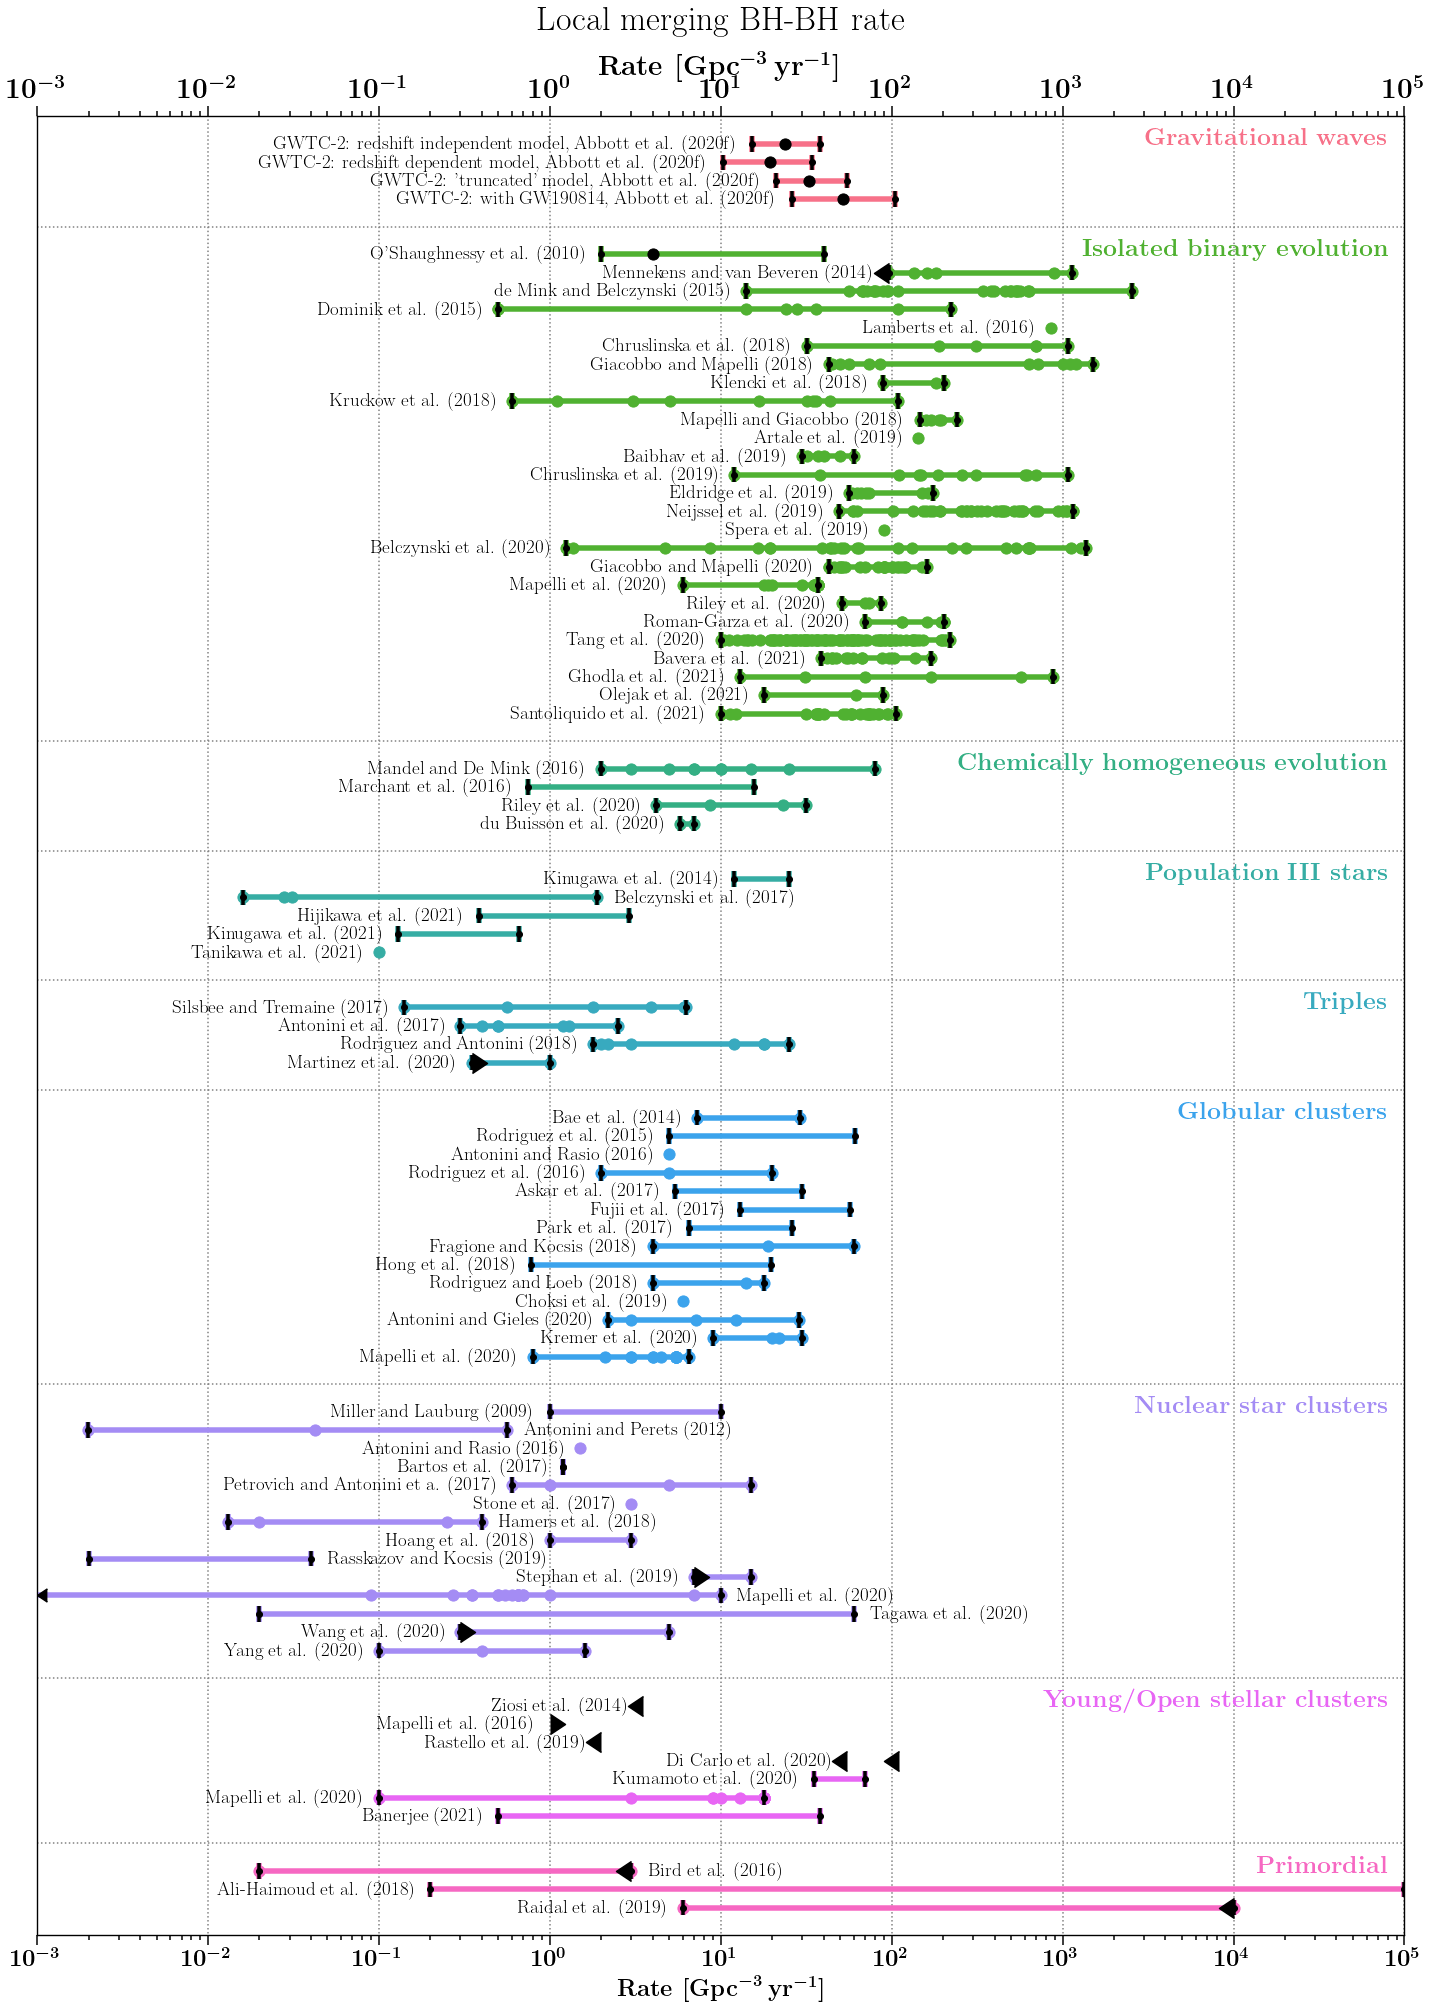

In [150]:
make_figure(DCOtype='BHBH', ordered='year')

../Data/BHNS_intrinsic_observations-GWs.csv
../Data/BHNS_intrinsic_isolated-binary-evolution.csv
17.0
../Data/BHNS_intrinsic_CHE.csv
../Data/BHNS_intrinsic_population-III.csv
../Data/BHNS_intrinsic_triples.csv
../Data/BHNS_intrinsic_globular-clusters.csv
1.0
15.0
../Data/BHNS_intrinsic_nuclear-clusters.csv
7
1.0
1.0
7.0
../Data/BHNS_intrinsic_young-stellar-clusters.csv
1.0
1
total v length: -55 
 including empty lines


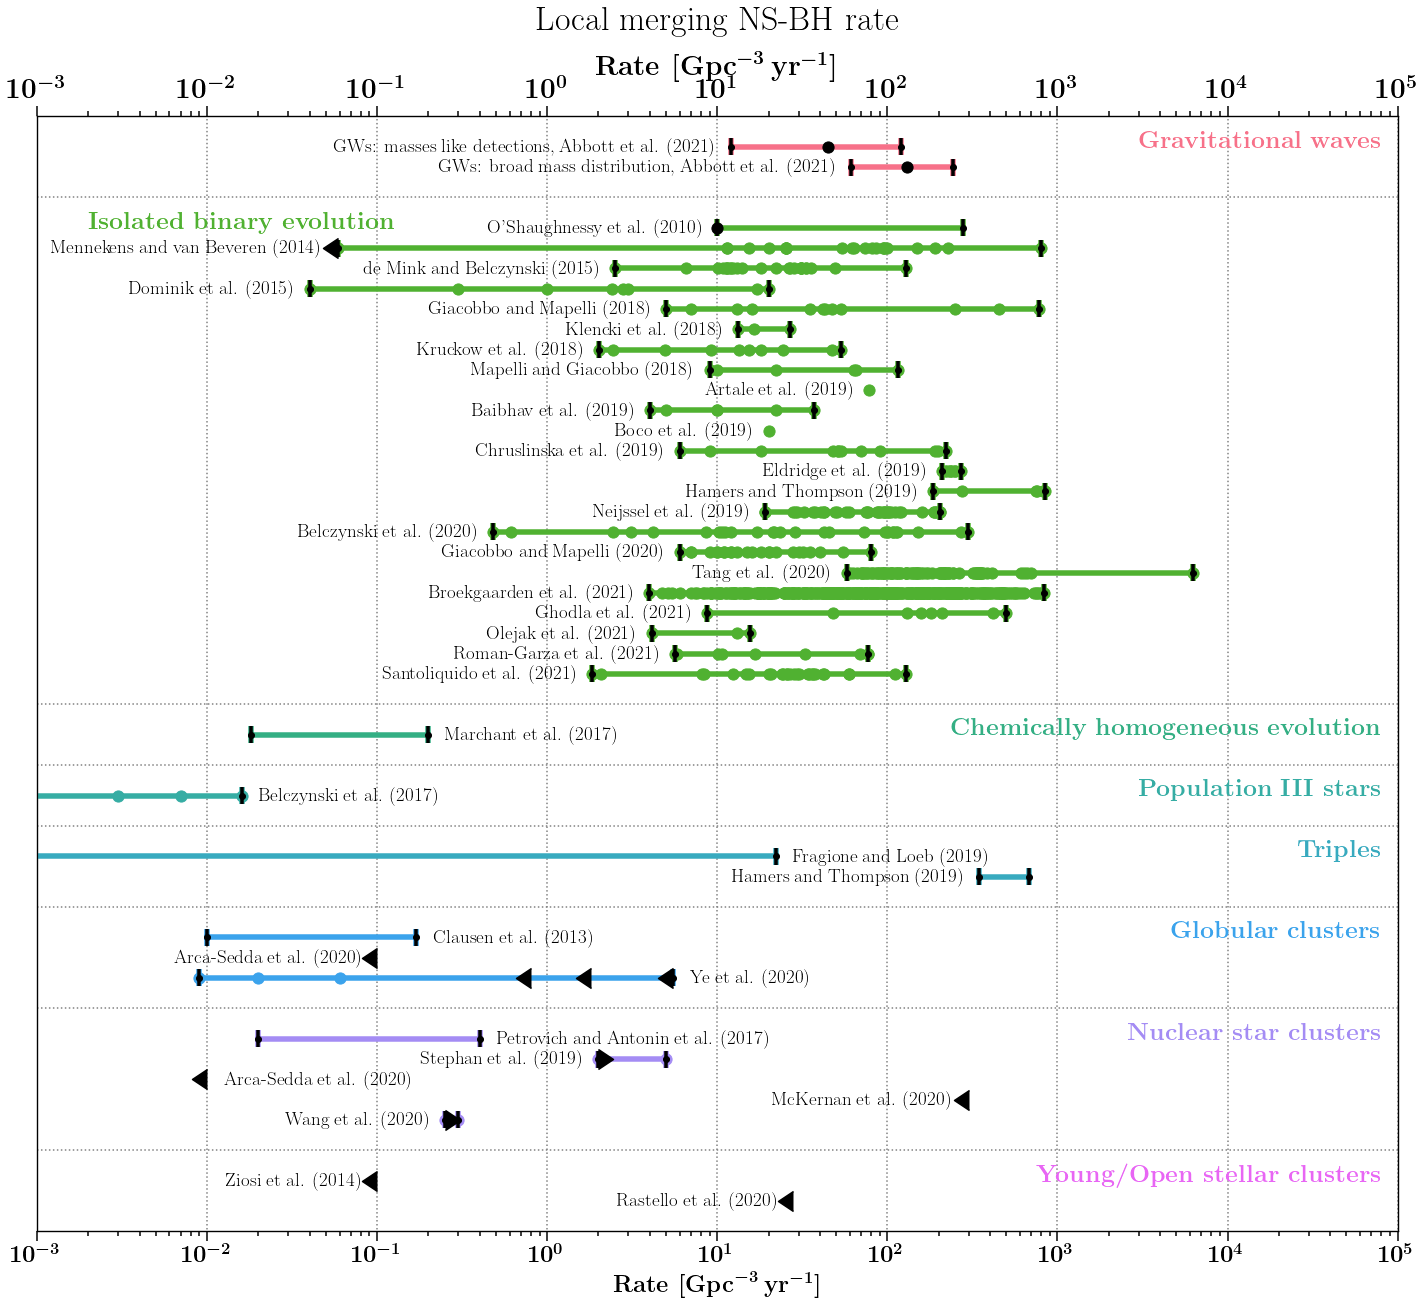

In [151]:
make_figure(DCOtype='BHNS', ordered='year')

../Data/NSNS_intrinsic_observations-GWs.csv
../Data/NSNS_intrinsic_observations-sGRBs.csv
../Data/NSNS_intrinsic_observations-kilonovae.csv
2.0
1
1
1
1
1
../Data/NSNS_intrinsic_observations-pulsars.csv
../Data/NSNS_intrinsic_isolated-binary-evolution.csv
17.0
../Data/NSNS_intrinsic_triples.csv
../Data/NSNS_intrinsic_globular-clusters.csv
15.0
../Data/NSNS_intrinsic_nuclear-clusters.csv
1.0
1.0
7.0
../Data/NSNS_intrinsic_young-stellar-clusters.csv
total v length: -70 
 including empty lines


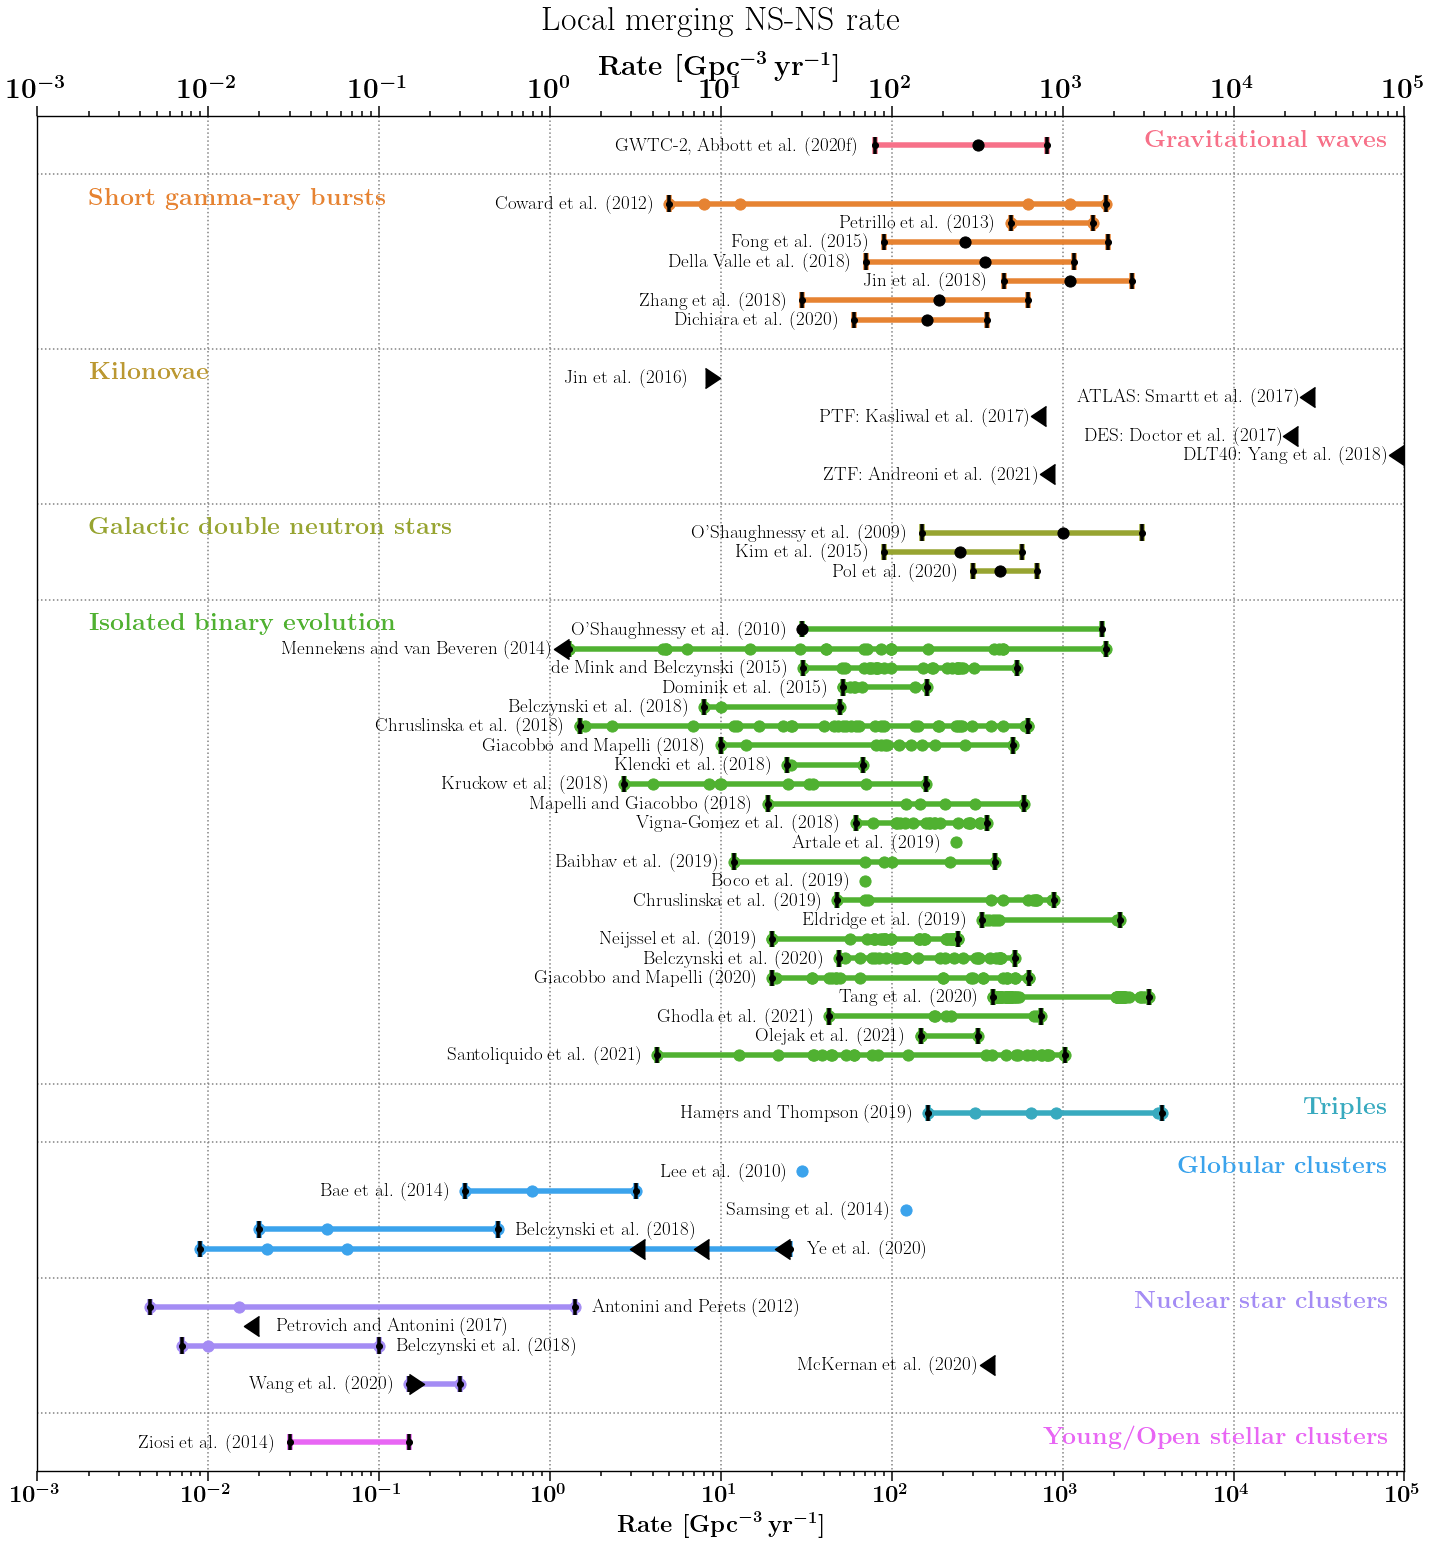

In [152]:
make_figure(DCOtype='NSNS',ordered='year')

# Make zoom in of single panel 

In [184]:

# all_names = ['observations', 'isolated binaries', 'CHE', 'dynamical: GC', 'dynamical: NC',  'dynamical: YSC', 'triples', 'pop-III', 'primordial', 'other']
all_names = [ 'GWs', 'sGRBs', 'kilonovae', 'pulsars',\
                       'isolated binaries',  'CHE','pop-III','triples', 'dynamical: GC', 'dynamical: NC',  'dynamical: YSC',  'primordial']

colors = sns.color_palette("husl", len(all_names))   
name_colors = dict(zip(all_names, colors))

name_labels = [ r'Gravitational waves', r'Short gamma-ray bursts', r'Kilonovae',  r'Galactic double neutron stars',\
                       r'Isolated binary evolution',  r'Chemically homogeneous evolution', r'Population III stars', r'Triples', r'Globular clusters', r'Nuclear star clusters',  r'Young/Open stellar clusters', r'Primordial']

names_label_dict = dict(zip(all_names, name_labels))



def make_up_axes(axe=None, DCOtype='BHNS',  df_names=['a', 'b'], ordered=None):
    
    xmin,xmax = 1E-3, 1E5
        
    # axes layout and mark up 
    axe.set_xscale('log')
    if DCOtype=='BHNS':
        xlabel = r'$\rm{NS-BH} \ \ \rm{Rate} \, \, [\rm{Gpc}^{-3} \, \rm{yr}^{-1}]$'
    elif DCOtype=='BHBH':
        xlabel = r'$\rm{BH-BH} \ \ \rm{Rate} \, \, [\rm{Gpc}^{-3} \, \rm{yr}^{-1}]$'
    elif DCOtype=='NSNS':
        xlabel = r'$\rm{NS-NS} \ \ \rm{Rate} \, \, [\rm{Gpc}^{-3} \, \rm{yr}^{-1}]$'
    axe = layoutAxesNoYlabel(axe, nameX=xlabel, nameY=r'$- $', fontsize=fs, setMinor=False)
    bps_names = []
    codes_names = []
   

    v_height=0
    yticks=[]    
    for ind_file, csv_filename in enumerate(df_names):
        
        df = pd.read_csv(csv_filename, header=0, skiprows=[0,1,2,3,4,6,7,8,9,10,11,12,13])

        df = df.iloc[:,1::2]

        rate_max_list = []
        codes_list = []
        
        df_codes = pd.read_csv(csv_filename, header=0, skiprows=[0,1,2,3,4,6,8,9,10,11,12,13])
        df_codes = df_codes.iloc[:,1::2]
        codes = df_codes.columns

        v_height+= -1
        if ordered=='max':
            for ind_n, name in enumerate(df.columns):
                rate = df[name]
                mask_notna = (df[name].notna())
                rate = rate[mask_notna]
                
                rate_max_list.append(np.max(rate))
                
                code = df_codes[name][0]
                codes_list.append(code)
            
            sorted_ind = np.argsort(np.asarray(rate_max_list))
        
            colum_list_sorted = df.columns[sorted_ind]
            codes_list_sorted = np.asarray(codes_list)[sorted_ind]
            
        elif ordered=='year':
            colum_list_sorted = df.columns 
            for ind_n, name in enumerate(df.columns):              
                code = df_codes[name][0]
                codes_list.append(code)
            codes_list_sorted = np.asarray(codes_list)
        
        
        elif ordered=='code':
            for ind_n, name in enumerate(df.columns):
                rate = df[name]
                mask_notna = (df[name].notna())
                rate = rate[mask_notna]
                
                rate_max_list.append(np.max(rate))
                
                code = df_codes[name][0]
                codes_list.append(code)
            
            sorted_ind = np.argsort(np.asarray(codes_list))
        
            colum_list_sorted = df.columns[sorted_ind]
            codes_list_sorted = np.asarray(codes_list)[sorted_ind]
            
        
        else:
            colum_list_sorted = df.columns        
            codes_list_sorted = codes 
            
            
        
        
        
        for ind_m, bps_model in enumerate(colum_list_sorted):
            bps_names.append(r'\textbf{%s}'%(bps_model) )
            codes_names.append(r'\textbf{%s}'%(codes_list_sorted[ind_m]) )
            yticks.append(v_height)
            v_height+=-1
        
        # add blank line after each channel 
        v_height+= -1 

#     axe.set_yticks(yticks)
#     axe.set_yticklabels(bps_names, rotation=0, fontsize=18)
    axe.set_yticks([])
#     axe.set_yticklabels([])
    
    axe.set_xlim(xmin, xmax)
    axe.set_ylim(-len(bps_names) -2*len(df_names)+0.5, 0.5)
    
    
    # second axes on the right     
    # add y labels on the right. 
#     ax2y = axe.twinx()
#     ax2y.set_yticks(yticks)
#     ax2y.set_yticklabels(codes_names, rotation=0, fontsize=14)
#     ax2y.set_ylim(-len(bps_names)-2*len(df_names),1)
#     ax2y = layoutAxesNoYlabel(ax2y, nameX=xlabel, nameY=r'code', fontsize=28, setMinor=False)
    

    # add x labels on top
    ax2x = axe.twiny()
    ax2x.set_xscale('log')   
    ax2x.set_xlim(xmin, xmax)
    ax2x = layoutAxesNoYlabel(ax2x, nameX=xlabel, nameY=r'code', fontsize=28, setMinor=False, second=True)
    
    
#     # SET OBSERVATIONAL GW LIMITs
    
#     DCOtypeIndexDict = {'BHBH':0, 'BHNS':1, 'NSNS':2}
#     ind_t=DCOtypeIndexDict[DCOtype]
    
#     xx = np.linspace(-100, 100, 100)
#     min_obs_rate = np.ones_like(xx)*ObservedRatesList[ind_t][0]
#     max_obs_rate = np.ones_like(xx)*ObservedRatesList[ind_t][1]
#     if DCOtype in ['BHBH','NSNS', 'BHNS']:
#         axe.fill_betweenx(y=xx, x1=min_obs_rate, x2=max_obs_rate, alpha=0.2, color=DCOtypeColorsDict[DCOtype], zorder=2)

        
        
        

#     elif DCOtype =='BHBH':
#         # for BHBH rates also plot intrinsic z=0 estimated rates based on a redshift model
#         min_obs_rate2 = np.ones_like(xx)*BHBHratez0[0]
#         max_obs_rate2 = np.ones_like(xx)*BHBHratez0[1]
#         axe.fill_betweenx(y=xx, x1=min_obs_rate2, x2=max_obs_rate2,  alpha=0.2, color=DCOtypeColorsDict[DCOtype], zorder=0)
#         axe.plot(min_obs_rate, xx,  c='k', linestyle=':', lw=1., alpha=0.5)
#         axe.plot(max_obs_rate, xx,  c='k', linestyle=':', lw=1., alpha=0.5)

#     # for BHNS plot that its a upper limit
#     if DCOtype=='BHNS':
#         axe.scatter(max_obs_rate, xx, marker=8, color=DCOtypeColorsDict[DCOtype], zorder=0, s=180)    

    
    

    return 
    
     
    

    
    
################################################################
################################################################
################################################################



# def plot_using_plotting_style(axe, ps, x_, y_, color):
    
#     msize = 120
#     if ps in [1,2,6,7]:
#         if ps in [1,6]:
#             mstyle = 8 # upper limit 
#         elif ps in [2,7]:
#             mstyle=9 # lower limit 
#         # draw upper or lower limit
#         axe.scatter(np.max(x_), np.max(y_), s=msize, c=color, zorder=1E3, marker=mstyle)
#     if ps in [3,4,5,6, 7, 8,9,10,11,13, 14, 15]:
#         axe.errorbar(x=[np.min(x_),np.max(x_)], y=[y_[0], y_[0]], yerr=2*[0.42],  color=color, zorder=5, lw=5)
#         if ps==4:
#             # plot center values
#             axe.scatter(x_[1], y_[1], s=msize, c='k', zorder=1E2, marker='o')
#         elif ps in [5,6,9,10,11,13]:
#             # plot all simulation values
#             axe.scatter(x_, y_, s=msize, c=np.asarray([color]), zorder=1E2, marker='o') 
#             if ps==9:
#                 axe.scatter(x_[0], y_[0], s=msize, c=np.asarray([color]), zorder=1E2, marker='*') 
#             if ps==11:
#                 axe.scatter(x_[0:2], y_[0:2], s=msize, c=np.asarray([color]), zorder=1E2, marker='*') 
#             if ps==13:
#                 axe.scatter(x_[0:3], y_[0:3], s=msize, c=np.asarray([color]), zorder=1E2, marker='*') 
#         elif ps in [8]:
#             xx= [x_[1], x_[4]]
#             yy= [y_[1], y_[4]]
#             axe.scatter(xx, yy, s=msize, c='k', zorder=1E2, marker='o')
        
#         if ps==10:
#             xmin=1E-3
#             axe.scatter(xmin, np.max(y_), s=msize+50, c='k', zorder=1E3, marker=4)
#     elif ps==12:
#         axe.scatter(x_, y_, s=msize, c=np.asarray([color]), zorder=1E2, marker='o')  
        
#     return 



def plot_using_plotting_style(axe, ps, x_, y_, color):
    
    
    
    if ps in [1,2,6,7, 14, 15 , 16, 17  ]:
        msize = 400
        if ps in [1,6,14]:
            mstyle = 8 # upper limit 
            axe.scatter(np.max(x_), np.max(y_), s=msize, c='k', zorder=1E6, marker=mstyle)
        elif ps in [17]:
            mstyle=8 # upper limit  (lower limit)
        # draw upper or lower limit
            axe.scatter(np.min(x_), np.min(y_), s=msize, c='k', zorder=1E6, marker=mstyle)            
        elif ps in [2,7]:
            mstyle=9 # lower limit 
        # draw upper or lower limit
            axe.scatter(np.min(x_), np.min(y_), s=msize, c='k', zorder=1E6, marker=mstyle)
        elif ps in [14]:
            mstyle=8
            # 1E4 is upper limit 
            axe.scatter(0.99*1E5, np.max(y_), s=msize, c='cyan', zorder=1E6, marker=mstyle)
        elif ps in [15]:
            mstyle=8
            # top 3 are upper limit  
            axe.scatter(x_[-3:], y_[-3:], s=msize, c='k', zorder=1E6, marker=mstyle)
        elif ps in [16]:
            mstyle=8
            # top 3 are upper limit  
            axe.scatter(x_[-2:], y_[-2:], s=msize, c='k', zorder=1E6, marker=mstyle)
        elif ps in [10]:
            mstyle=9
            # 1E-3 is lower limit y axis 
            axe.scatter(1E-3, np.max(y_), s=msize, c='cyan', zorder=1E6, marker=mstyle)
        print(ps)
    msize = 125
    if ps in [3,4,5,6, 7, 8,9,10,11,13, 14, 15, 17 ]:
        axe.errorbar(x=[np.min(x_),np.max(x_)], y=[y_[0], y_[0]], yerr=2*[0.42], color=color, zorder=5, lw=7.5, ecolor=color)
        axe.errorbar(x=[np.min(x_),np.max(x_)], y=[y_[0], y_[0]], yerr=2*[0.42], fmt='o', zorder=1E5, lw=5.5, ecolor='k', color='k')
        if ps==4:
            # plot center values
            axe.scatter(x_[1], y_[1], s=msize, c='k', zorder=1E2, marker='o')
        elif ps==3:
            # don't plot scatter points
            pass
        elif ps==15:
            axe.scatter(x_[0:3], y_[0:3], s=msize, color=[color], zorder=1E2, marker='o') 
        else:
            axe.scatter(x_, y_, s=msize, color=[color], zorder=1E2, marker='o') 

    if ps==10:
            xmin=1E-3
            axe.scatter(xmin, np.max(y_), s=msize+50, c='k', zorder=1E3, marker=4)
    elif ps==12:
        axe.scatter(x_, y_, s=msize, c=np.asarray([color]), zorder=1E2, marker='o')  
        
    return 



# def plot_using_plotting_style(axe, ps, x_, y_, color):
    
#     msize = 120
# #     if ps in [1,2,6,7]:
# #         if ps in [1,6]:
# #             mstyle = 8 # upper limit 
# #         elif ps in [2,7]:
# #             mstyle=9 # lower limit 
# #         # draw upper or lower limit
# #         print(ps)
# #         axe.scatter(np.max(x_), np.max(y_), s=msize, c=color, zorder=1E3, marker=mstyle)
#     if ps in range(20):
#         axe.errorbar(x=[np.min(x_),np.max(x_)], y=[y_[0], y_[0]], yerr=2*[0.42], color=color, zorder=5, lw=5)
#         print(color)
#         axe.scatter(x_, y_, s=msize, color=[color], zorder=1E2, marker='o') 
 
        
#     return 

    
            
                
            
        



def plotDCOrates(axe, df_names, df_colordict, df_labels, DCOtype='BHNS', ordered=None):
    

    
    ############## 2nd panel on the right ##########################
    ################################################################
    
    

    v_height=0
    for ind_file, csv_filename in enumerate(df_names):
        
        v_height_top = int(v_height) +.5

        
        medians_list = [] # list where we will save the medians of each rate estimate
        print(csv_filename)
        
        df = pd.read_csv(csv_filename, header=0, skiprows=[0,1,2,3,4,6,7,8,9,10,11,12,13])
        df = df.iloc[:,1::2]
        
        # plotting style 
        df_ps = pd.read_csv(csv_filename, header=0, skiprows=[0,1,2,3,4,6,7,8,10,11,12,13])
        df_ps = df_ps.iloc[:,1::2]

        rate_max_list = []
        codes_list = []
        
        df_codes = pd.read_csv(csv_filename, header=0, skiprows=[0,1,2,3,4,6,8,9,10,11,12,13])
        df_codes = df_codes.iloc[:,1::2]
        
        labelname = df_labels[ind_file]
        
        rate_max_list = []
        plot_styles   = []
        
        if ordered=='max':
            for ind_n, name in enumerate(df.columns):
                rate = df[name]
                mask_notna = (df[name].notna())
                rate = rate[mask_notna]

                rate_max_list.append(np.max(rate))
            
            sorted_ind = np.argsort(np.asarray(rate_max_list))
        
            colum_list = df.columns[sorted_ind]
        
        
        elif ordered=='code':
            for ind_n, name in enumerate(df.columns):
                rate = df[name]
                mask_notna = (df[name].notna())
                rate = rate[mask_notna]

                rate_max_list.append(np.max(rate))
                code = df_codes[name][0]
                codes_list.append(code)
            
            sorted_ind = np.argsort(np.asarray(codes_list))
            colum_list = df.columns[sorted_ind]
        
            
            ##
            colum_list_sorted = df.columns[sorted_ind]
            codes_list_sorted = np.asarray(codes_list)[sorted_ind]
            
    
        

        elif ordered=='year':
            colum_list = df.columns
            colum_list_sorted = df.columns
#             codes_list_sorted = np.asarray(codes_list)[sorted_ind]
            
        else:
            colum_list = df.columns
            
            
        # obtain ordered:
        
        
        v_height+= -1
        for ind_n, name in enumerate(colum_list):
            
            
            
            rate = df[name]
            mask_notna = (df[name].notna())
            rate = rate[mask_notna]

            # read in plotting style 
            ps = df_ps[name][0]
            if ps in range(20):
                plot_using_plotting_style(axe, ps, x_=np.asarray(rate), y_=v_height*np.ones_like(rate), color=df_colordict[labelname])
            else: 
                plot_using_plotting_style(axe, ps=3, x_=np.asarray(rate), y_=v_height*np.ones_like(rate), color=df_colordict[labelname])
#                 axe.scatter(rate,  v_height*np.ones_like(rate), s=105, c='gray', zorder=1)
#                 axe.errorbar(x=[np.min(rate),np.max(rate)], y=2*[v_height], yerr=2*[0.3], color=df_colordict[labelname], zorder=5, lw=5)

            medians_list.append(np.median(rate))


            ## ADD LABELS to the left of the measurements 
            if (min(rate)>2*1E-2) & (min(rate)<=1E5):
                axe.text(min(rate)/1.25, v_height, s=colum_list_sorted[ind_n], ha='right', va='center', fontsize=fs-5)
            elif (min(rate)>1E5):
                axe.text(1E5/1.5, v_height, s=colum_list_sorted[ind_n], ha='right', va='center', fontsize=fs-5)   
            # plot on the right side 
            elif (min(rate)<=2*1E-2) :
                axe.text(max(rate)*1.25, v_height, s=colum_list_sorted[ind_n], ha='left', va='center', fontsize=fs-5)
# #             else: 
#                 axe.text(1.5*1E-3, v_height+1, s=colum_list_sorted[ind_n], ha='left', va='center', fontsize=fs-5)
#             if (max(rate)<1E4) & (min(rate)<1E4) & (min(rate)>1E-3):
#                 axe.text(max(rate)*1.1, v_height, s=codes_list_sorted[ind_n], ha='left', va='center', fontsize=fs-4)
                
            switchLabelLeft=False
            # if plotting the first rate, add in text which type of formation channel we are plotting 
            if ind_n==(0): #len(df.columns)-1
                dict_name = df_labels[ind_file]
                # plot the following ones as exception somewhere else:
                if ((DCOtype=='BHNS') & (dict_name=='isolated binaries')) | ((DCOtype=='NSNS') & (dict_name=='isolated binaries')):
                    switchLabelLeft = True
                elif (DCOtype=='NSNS') & (dict_name=='sGRBs') | (DCOtype=='NSNS') & (dict_name=='kilonovae') | (DCOtype=='NSNS') & (dict_name=='pulsars'):
                    switchLabelLeft = True 
                    
                if switchLabelLeft==True:
                    axe.text(2*1E-3, v_height+0.3, s=r'\textbf{%s}'%names_label_dict[dict_name] , rotation = 0, fontsize = fs+1, color=df_colordict[labelname], ha = 'left', va='center', weight = 'bold')
                else:
                    axe.text(8*1E4,  v_height+0.3, s=r'\textbf{%s}'%names_label_dict[dict_name] , rotation = 0, fontsize = fs+1, color=df_colordict[labelname], ha = 'right', va='center', weight = 'bold')
    #                 axe.text(8*1E4, v_height, s=r'\textbf{%s}'%df_labels[ind_file] , rotation = 0, fontsize = fs+8, color=df_colordict[labelname], ha = 'right', va='center', weight = 'bold')

            v_height+= -1  # height of rate to plot on vertical axes  


            
        v_height+= -1

        v_height_bottom = int(v_height)+0.5

        
        if ind_file!=(len(df_names)-1):   
            axe.plot([1E-3, 1E5],  [v_height+0.5]*2, lw=1.5, c='gray', ls=':', zorder=0)
    
#         # add bar with median values of the medians from this channel/list 
#         super_median = np.median(medians_list)
#         axe.fill_between(x=[super_median/1.5, super_median*1.5], y1=[v_height_bottom]*2, y2=[v_height_top]*2, color=df_colordict[labelname], alpha=0.2, zorder=1)
        
    
    print('total v length: %s \n including empty lines'%v_height)
    return 



def draw_vlines(axe, v_values):
    """ draws vertical grid lines at values in the v_values list """
    
    for v_ in v_values:
        # draw vertical line that looks similar to grid line 
#         axe.plot([v_, v_], [-1E5, 2], lw=2, c='gray', ls='-', zorder=0)
        axe.plot([v_, v_], [-1E5, 2], lw=1.5, c='gray', ls=':', zorder=0)
        
    return 



    
    
    





    
    

def make_figure_zoom(DCOtype='BHNS', ordered='max', label='GWs', vlength=6):
    
        
    names_ = ['../Data/'+DCOtype+'_intrinsic_observations-GWs.csv', '../Data/'+DCOtype+'_intrinsic_observations-sGRBs.csv',\
             '../Data/'+DCOtype+'_intrinsic_observations-kilonovae.csv' ,\
              '../Data/'+DCOtype+'_intrinsic_observations-pulsars.csv',\
               '../Data/'+DCOtype+'_intrinsic_isolated-binary-evolution.csv', '../Data/'+DCOtype+'_intrinsic_CHE.csv',
               '../Data/'+DCOtype+'_intrinsic_population-III.csv','../Data/'+DCOtype+'_intrinsic_triples.csv',\
               '../Data/'+DCOtype+'_intrinsic_globular-clusters.csv',\
              '../Data/'+DCOtype+'_intrinsic_nuclear-clusters.csv', '../Data/'+DCOtype+'_intrinsic_young-stellar-clusters.csv', 
                '../Data/'+DCOtype+'_intrinsic_primordial.csv']


    labels_ = ['GWs', 'sGRBs', 'kilonovae', 'pulsars', \
                   'isolated binaries', 'CHE', 'pop-III', \
               'triples','dynamical: GC', 'dynamical: NC', \
               'dynamical: YSC',    'primordial']
    
    
    
    label_to_names_dict = dict(zip(labels_, names_))
    
    ncols, nrows=1,1
    if DCOtype in ['BHBH']:
        s_text = r'Local merging BH-BH rate' 
#         names =   ['../Data/'+DCOtype+'_intrinsic_observations-GWs.csv',\
#                    '../Data/'+DCOtype+'_intrinsic_isolated-binary-evolution.csv', '../Data/'+DCOtype+'_intrinsic_CHE.csv',
#                    '../Data/'+DCOtype+'_intrinsic_population-III.csv','../Data/'+DCOtype+'_intrinsic_triples.csv',\
#                    '../Data/'+DCOtype+'_intrinsic_globular-clusters.csv',\
#                   '../Data/'+DCOtype+'_intrinsic_nuclear-clusters.csv', '../Data/'+DCOtype+'_intrinsic_young-stellar-clusters.csv', 
#                     '../Data/'+DCOtype+'_intrinsic_primordial.csv']
#         rate_labels = ['GWs','isolated binaries', 'CHE', 'pop-III', 'triples','dynamical: GC', 'dynamical: NC',  'dynamical: YSC',    'primordial']
#         d1_, d2_ = 20,28
       

        
    elif DCOtype=='BHNS': 
        s_text = r'Local merging NS-BH rate' 
        
#         names =   ['../Data/'+DCOtype+'_intrinsic_observations-GWs.csv',\
#                    '../Data/'+DCOtype+'_intrinsic_isolated-binary-evolution.csv', '../Data/'+DCOtype+'_intrinsic_CHE.csv',
#                    '../Data/'+DCOtype+'_intrinsic_population-III.csv', '../Data/'+DCOtype+'_intrinsic_triples.csv',\
#                    '../Data/'+DCOtype+'_intrinsic_globular-clusters.csv',\
#                   '../Data/'+DCOtype+'_intrinsic_nuclear-clusters.csv', '../Data/'+DCOtype+'_intrinsic_young-stellar-clusters.csv'\
#                    ]
#         rate_labels = ['GWs','isolated binaries', 'CHE', 'pop-III',  'triples' , 'dynamical: GC', 'dynamical: NC',  'dynamical: YSC']
#         d1_ = 20 
#         d2_ = 22*(55/99) +6

    elif DCOtype=='NSNS':
        
        s_text = r'Local merging NS-NS rate'
        

    rate_labels = [label]
    names = [label_to_names_dict[label]]
    
    d1_ = 18
    d2_ = 22*(vlength/50) +6
    
    d1, d2 = d1_, d2_
    f, axe= plt.subplots(ncols=ncols,nrows=nrows,figsize=(d1,d2), gridspec_kw={"width_ratios":[1], "height_ratios":[1]})     
    
    
#     text_DCO = r'\textbf{%s}'%DCOtype + '\n' + r'\textbf{merger rates}'
#     textbox_props = dict(boxstyle='round', facecolor='gray', alpha=0.1)
    

    plotDCOrates(axe=axe, df_names=names, df_colordict=name_colors, df_labels=rate_labels, DCOtype=DCOtype, ordered=ordered)
    make_up_axes(axe, DCOtype, df_names=names,ordered=ordered)
    
    draw_vlines(axe=axe, v_values=[1E-4, 1E-3, 1E-2, 1E-1, 1E0, 1E1, 1E2, 1E3, 1E4, 1E5])
    
    
#     plt.title(s_text, fontsize=34,  pad=20)
        
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)#2)
    plt.savefig('./Rates_' +DCOtype + '_' + ordered + '_' + label+ '_zoom.png', dpi=300, transparent=False)#,\
    plt.savefig('./Rates_' +DCOtype + '_' + ordered + '_' + label+ '_zoom.pdf')
#                bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

    plt.close()
    



../Data/NSNS_intrinsic_observations-GWs.csv
total v length: -3 
 including empty lines


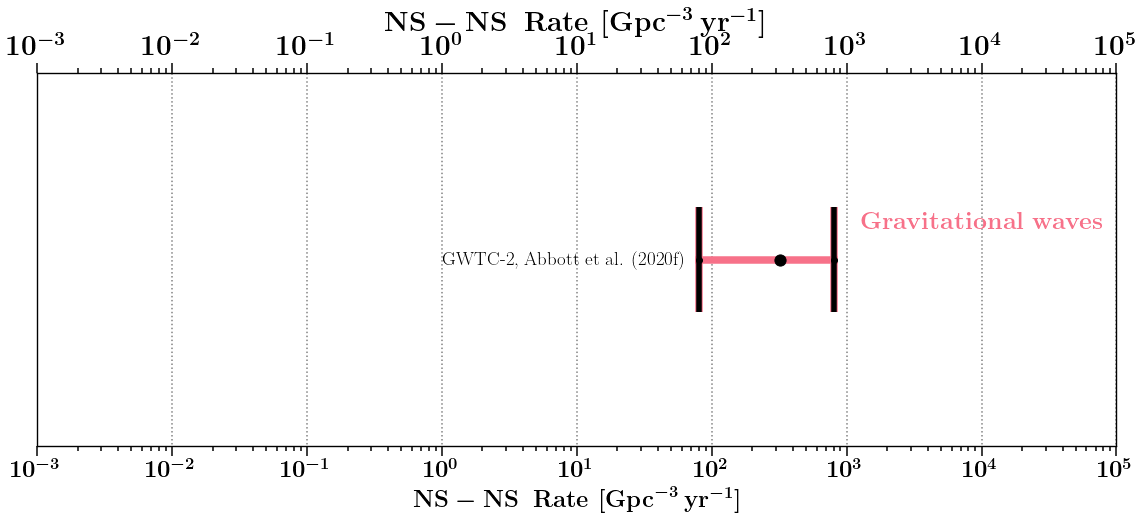

../Data/NSNS_intrinsic_observations-sGRBs.csv
total v length: -9 
 including empty lines


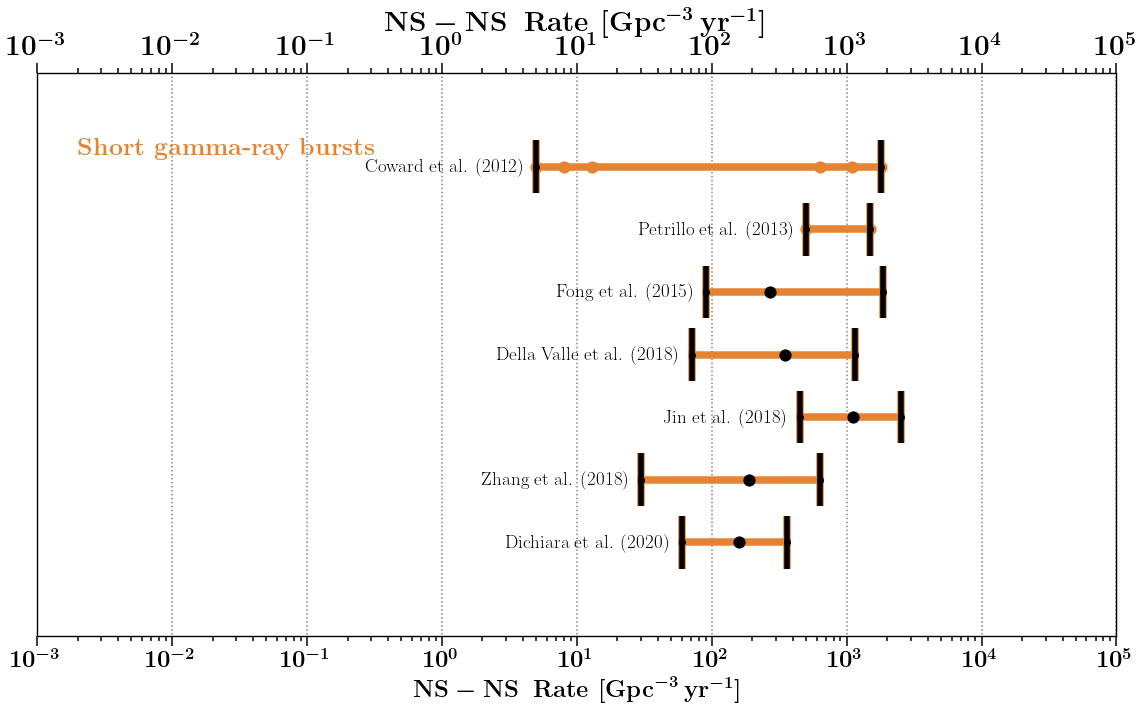

../Data/NSNS_intrinsic_observations-kilonovae.csv
2.0
1
1
1
1
1
total v length: -8 
 including empty lines


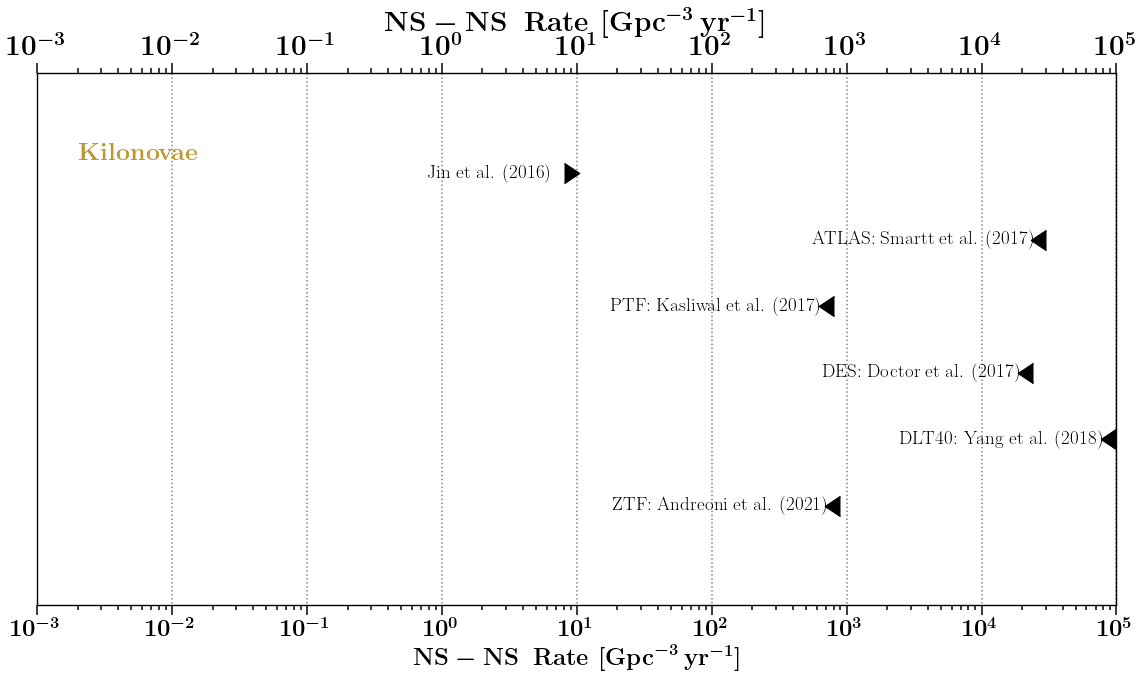

../Data/NSNS_intrinsic_observations-pulsars.csv
total v length: -5 
 including empty lines


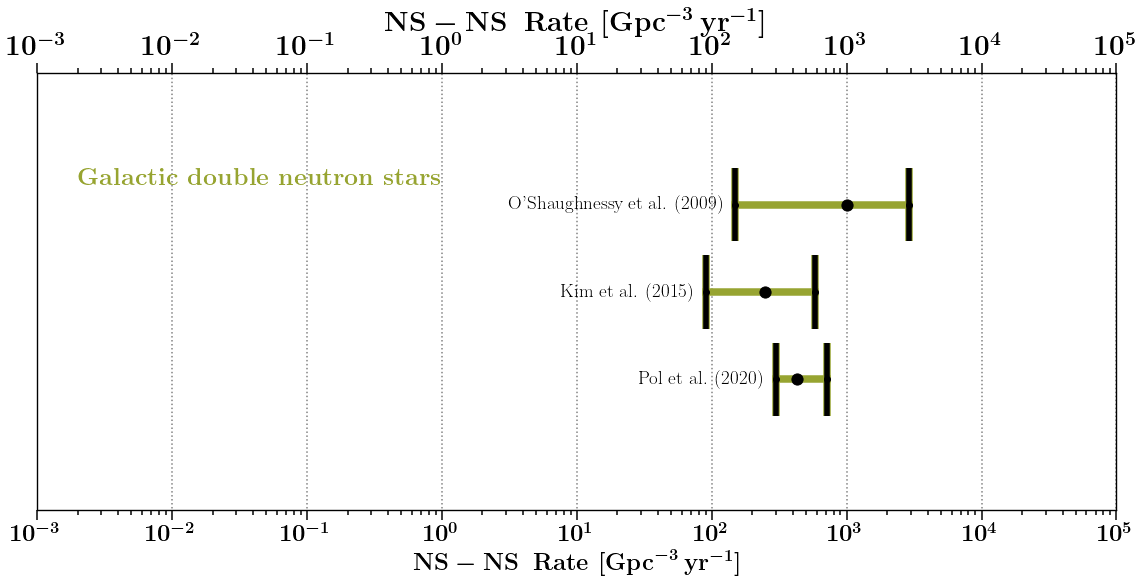

../Data/NSNS_intrinsic_isolated-binary-evolution.csv
17.0
total v length: -25 
 including empty lines


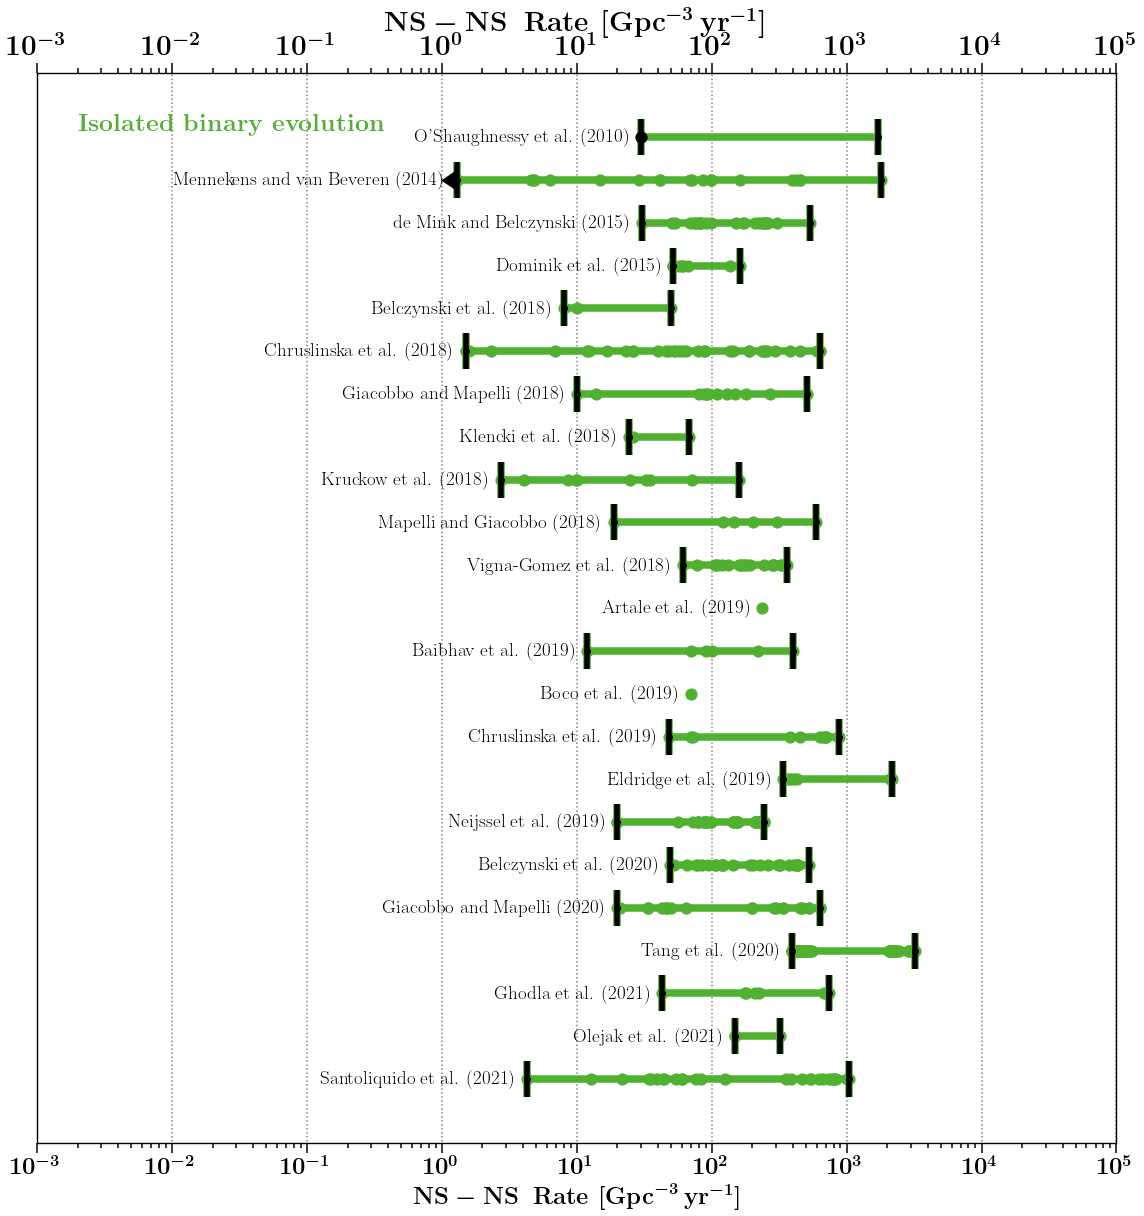

../Data/NSNS_intrinsic_triples.csv
total v length: -3 
 including empty lines


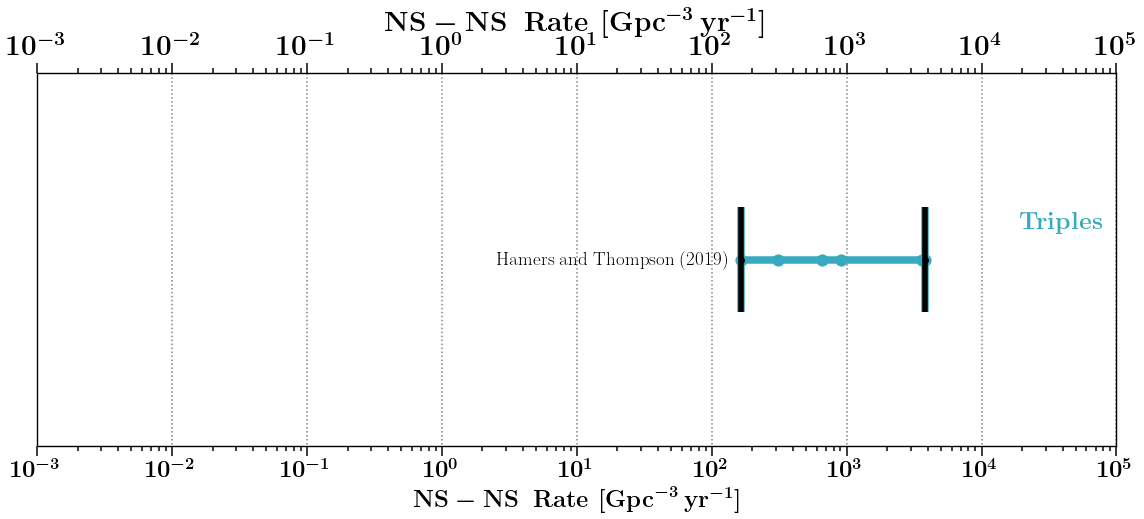

../Data/NSNS_intrinsic_globular-clusters.csv
15.0
total v length: -7 
 including empty lines


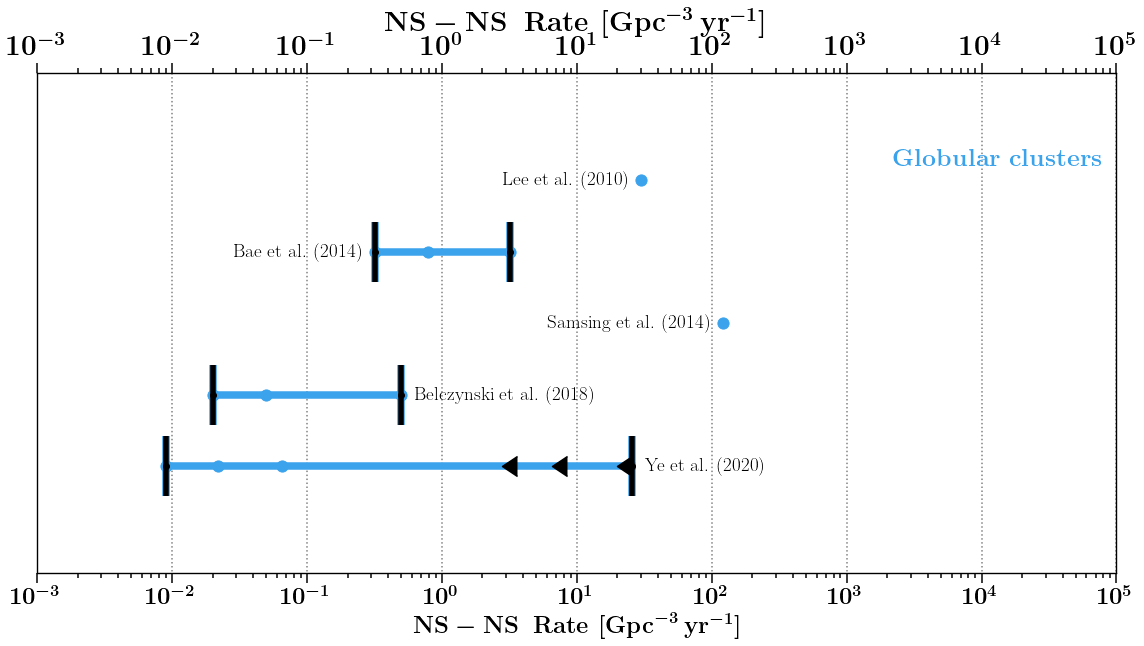

../Data/NSNS_intrinsic_nuclear-clusters.csv
1.0
1.0
7.0
total v length: -7 
 including empty lines


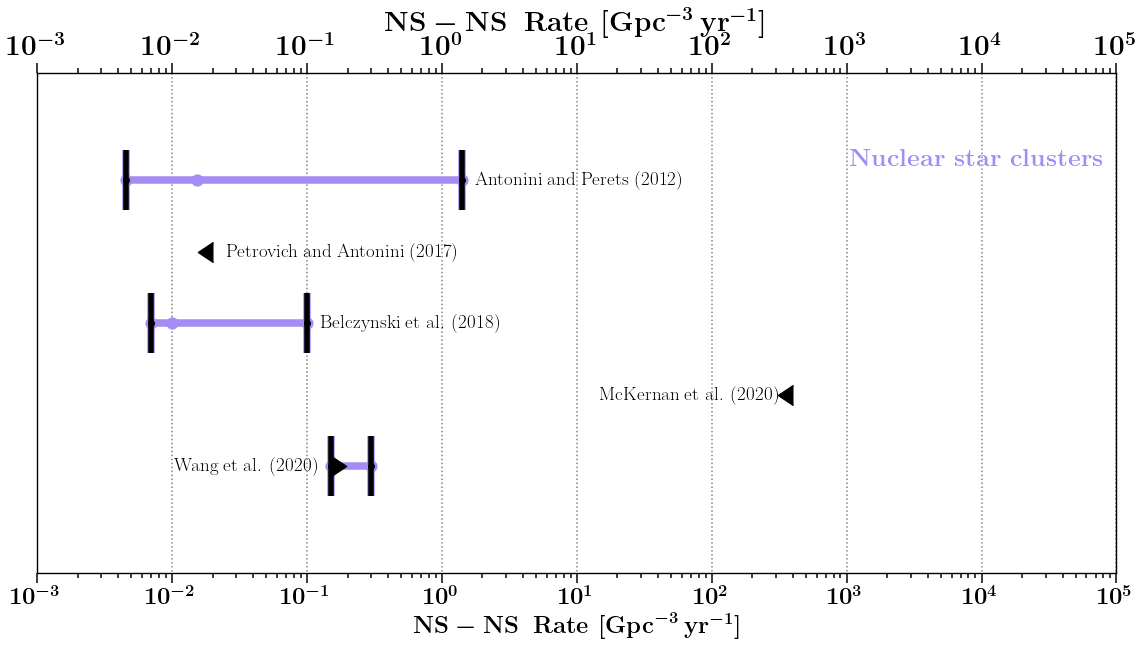

../Data/NSNS_intrinsic_young-stellar-clusters.csv
total v length: -3 
 including empty lines


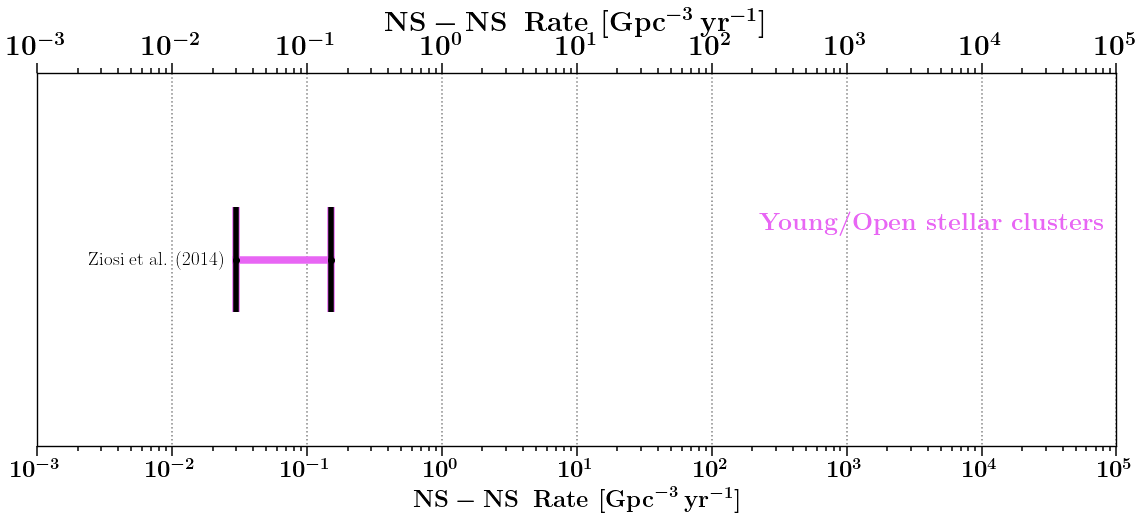

In [191]:
for DCOtype in ['BHBH', 'BHNS', 'NSNS']:    
    if DCOtype=='BHBH':
        labels =['GWs', \
                           'isolated binaries', 'CHE', 'pop-III', \
                       'triples','dynamical: GC', 'dynamical: NC', \
                       'dynamical: YSC',    'primordial']
        vlengths = [4, 28, 6, 7, 6, 16, 16, 9]
    elif DCOtype=='NSNS':
        labels =['GWs', 'sGRBs', 'kilonovae', 'pulsars', \
                           'isolated binaries',  \
                       'triples','dynamical: GC', 'dynamical: NC', \
                       'dynamical: YSC']
        vlengths = [3, 9, 8, 5, 25, 3, 7,7, 3]
    elif DCOtype=='BHNS':
        labels = ['GWs', \
                           'isolated binaries', 'CHE', 'pop-III', \
                       'triples','dynamical: GC', 'dynamical: NC', \
                       'dynamical: YSC']
        vlengths = [4, 25, 3, 3, 4, 5, 7, 4]
        
        
    for ind_l, label in enumerate(labels):

        make_figure_zoom(DCOtype, ordered='year', label=label, vlength=vlengths[ind_l])

In [235]:
A = [1, 2, 3, 4]


np.invert(A)

array([-2, -3, -4, -5])

# Horizontal 

In [264]:

# Reversing a list using reversed()
def Reverse(lst):
    return [ele for ele in reversed(lst)]


# all_names = ['observations', 'isolated binaries', 'CHE', 'dynamical: GC', 'dynamical: NC',  'dynamical: YSC', 'triples', 'pop-III', 'primordial', 'other']
all_names = [ 'GWs', 'sGRBs', 'kilonovae', 'pulsars',\
                       'isolated binaries',  'CHE','pop-III','triples', 'dynamical: GC', 'dynamical: NC',  'dynamical: YSC',  'primordial']

colors = sns.color_palette("husl", len(all_names))   
name_colors = dict(zip(all_names, colors))

name_labels = [ r'Gravitational waves', r'Short gamma-ray bursts', r'Kilonovae',  r'Galactic double neutron stars',\
                       r'Isolated binary evolution',  r'Chemically homogeneous evolution', r'Population III stars', r'Triples', r'Globular clusters', r'Nuclear star clusters',  r'Young/Open stellar clusters', r'Primordial']

names_label_dict = dict(zip(all_names, name_labels))



def make_up_axes(axe=None, DCOtype='BHNS',  df_names=['a', 'b'], ordered=None, ylim=[0,1]):
    
    xmin,xmax = 1E-2, 1E4
        
    # axes layout and mark up 
    axe.set_yscale('log')
    if DCOtype=='BHNS':
        xlabel = r'$\rm{NS-BH} \ \ \rm{Rate} \, \, [\rm{Gpc}^{-3} \, \rm{yr}^{-1}]$'
    elif DCOtype=='BHBH':
        xlabel = r'$\rm{BH-BH} \ \ \rm{Rate} \, \, [\rm{Gpc}^{-3} \, \rm{yr}^{-1}]$'
    elif DCOtype=='NSNS':
        xlabel = r'$\rm{NS-NS} \ \ \rm{Rate} \, \, [\rm{Gpc}^{-3} \, \rm{yr}^{-1}]$'
    xlabel = r'$ \rm{Rate} \, \, [\rm{Gpc}^{-3} \, \rm{yr}^{-1}]$'

    bps_names = []
    codes_names = []
   

    v_height=0
    yticks=[]    
    for ind_file, csv_filename in enumerate(df_names):
        
        df = pd.read_csv(csv_filename, header=0, skiprows=[0,1,2,3,4,6,7,8,9,10,11,12,13])

        df = df.iloc[:,1::2]

        rate_max_list = []
        codes_list = []
        
        df_codes = pd.read_csv(csv_filename, header=0, skiprows=[0,1,2,3,4,6,8,9,10,11,12,13])
        df_codes = df_codes.iloc[:,1::2]
        codes = df_codes.columns

        v_height+= -1
        if ordered=='max':
            for ind_n, name in enumerate(df.columns):
                rate = df[name]
                mask_notna = (df[name].notna())
                rate = rate[mask_notna]
                
                rate_max_list.append(np.max(rate))
                
                code = df_codes[name][0]
                codes_list.append(code)
            
            sorted_ind = np.argsort(np.asarray(rate_max_list))
        
            colum_list_sorted = df.columns[sorted_ind]
            codes_list_sorted = np.asarray(codes_list)[sorted_ind]
            
        elif ordered=='year':
            colum_list_sorted = df.columns 
            for ind_n, name in enumerate(df.columns):              
                code = df_codes[name][0]
                codes_list.append(code)
            codes_list_sorted = np.asarray(codes_list)
        
        
        elif ordered=='code':
            for ind_n, name in enumerate(df.columns):
                rate = df[name]
                mask_notna = (df[name].notna())
                rate = rate[mask_notna]
                
                rate_max_list.append(np.max(rate))
                
                code = df_codes[name][0]
                codes_list.append(code)
            
            sorted_ind = np.argsort(np.asarray(codes_list))
        
            colum_list_sorted = df.columns[sorted_ind]
            codes_list_sorted = np.asarray(codes_list)[sorted_ind]
            
        
        else:
            colum_list_sorted = df.columns        
            codes_list_sorted = codes 
            
            
        
        
        
        for ind_m, bps_model in enumerate(colum_list_sorted):
            bps_names.append(r'\textbf{%s}'%(bps_model) )
            codes_names.append(r'\textbf{%s}'%(codes_list_sorted[ind_m]) )
            yticks.append(v_height)
            v_height+=-1
        
        # add blank line after each channel 
        v_height+= -1 

#     axe.set_yticks(yticks)
#     axe.set_yticklabels(bps_names, rotation=0, fontsize=18)
    axe.set_xticks([])
#     axe.set_yticklabels([])
    
    axe.set_ylim(ylim[0], ylim[1])
    axe.set_xlim(-len(bps_names) -2*len(df_names)+0.5, 0.5)
    
    
    # second axes on the right     
    # add y labels on the right. 
#     ax2y = axe.twinx()
#     ax2y.set_yticks(yticks)
#     ax2y.set_yticklabels(codes_names, rotation=0, fontsize=14)
#     ax2y.set_ylim(-len(bps_names)-2*len(df_names),1)
#     ax2y = layoutAxesNoYlabel(ax2y, nameX=xlabel, nameY=r'code', fontsize=28, setMinor=False)
    

    # add x labels on top
    ax2x = axe.twinx()
    ax2x.set_yscale('log')   
    ax2x.set_ylim(ylim[0], ylim[1])
    ax2x = layoutAxesNoXlabel(ax2x, nameY=xlabel, nameX=xlabel, fontsize=28, setMinor=False, second=True)
    axe  = layoutAxesNoXlabel(axe,  nameY=xlabel, nameX=xlabel, fontsize=28, setMinor=False, second=False)
    
    
#     # SET OBSERVATIONAL GW LIMITs
    
#     DCOtypeIndexDict = {'BHBH':0, 'BHNS':1, 'NSNS':2}
#     ind_t=DCOtypeIndexDict[DCOtype]
    
#     xx = np.linspace(-100, 100, 100)
#     min_obs_rate = np.ones_like(xx)*ObservedRatesList[ind_t][0]
#     max_obs_rate = np.ones_like(xx)*ObservedRatesList[ind_t][1]
#     if DCOtype in ['BHBH','NSNS', 'BHNS']:
#         axe.fill_betweenx(y=xx, x1=min_obs_rate, x2=max_obs_rate, alpha=0.2, color=DCOtypeColorsDict[DCOtype], zorder=2)

        
        
        

#     elif DCOtype =='BHBH':
#         # for BHBH rates also plot intrinsic z=0 estimated rates based on a redshift model
#         min_obs_rate2 = np.ones_like(xx)*BHBHratez0[0]
#         max_obs_rate2 = np.ones_like(xx)*BHBHratez0[1]
#         axe.fill_betweenx(y=xx, x1=min_obs_rate2, x2=max_obs_rate2,  alpha=0.2, color=DCOtypeColorsDict[DCOtype], zorder=0)
#         axe.plot(min_obs_rate, xx,  c='k', linestyle=':', lw=1., alpha=0.5)
#         axe.plot(max_obs_rate, xx,  c='k', linestyle=':', lw=1., alpha=0.5)

#     # for BHNS plot that its a upper limit
#     if DCOtype=='BHNS':
#         axe.scatter(max_obs_rate, xx, marker=8, color=DCOtypeColorsDict[DCOtype], zorder=0, s=180)    

    
    

    return 
    
     
    

    




def plot_using_plotting_style(axe, ps, x_, y_, color):
    
    
    
    if ps in [1,2,6,7, 14, 15 , 16, 17  ]:
        msize = 400
        if ps in [1,6,14]:
            mstyle = 7 # upper limit 
            axe.scatter(np.max(y_), np.max(x_),  s=msize, c='k', zorder=1E6, marker=mstyle)
        elif ps in [17]:
            mstyle=7 # upper limit  (lower limit)
        # draw upper or lower limit
            axe.scatter(np.min(y_), np.min(x_),  s=msize, c='k', zorder=1E6, marker=mstyle)            
        elif ps in [2,7]:
            mstyle=6 # lower limit 
        # draw upper or lower limit
            axe.scatter(np.min(y_), np.min(x_),  s=msize, c='k', zorder=1E6, marker=mstyle)
        elif ps in [14]:
            mstyle=7
            # 1E4 is upper limit 
            axe.scatter(np.max(y_), 0.99*1E5,  s=msize, c='cyan', zorder=1E6, marker=mstyle)
        elif ps in [15]:
            mstyle=7
            # top 3 are upper limit  
            axe.scatter(y_[-3:], x_[-3:], s=msize, c='k', zorder=1E6, marker=mstyle)
        elif ps in [16]:
            mstyle=7
            # top 3 are upper limit  
            axe.scatter(y_[-2:], x_[-2:], s=msize, c='k', zorder=1E6, marker=mstyle)
        elif ps in [10]:
            mstyle=6
            # 1E-3 is lower limit y axis 
            axe.scatter(np.max(y_), 1E-3,  s=msize, c='cyan', zorder=1E6, marker=mstyle)
        print(ps)
    msize = 125
    if ps in [3,4,5,6, 7, 8,9,10,11,13, 14, 15, 17 ]:
        axe.errorbar(y=[np.min(x_),np.max(x_)], x=[y_[0], y_[0]], xerr=2*[0.42], color=color, zorder=5, lw=7.5, ecolor=color)
        axe.errorbar(y=[np.min(x_),np.max(x_)], x=[y_[0], y_[0]], xerr=2*[0.42], fmt='o', zorder=1E5, lw=5.5, ecolor='k', color='k')
        if ps==4:
            # plot center values
            axe.scatter(y_[1], x_[1], s=msize, c='k', zorder=1E2, marker='o')
        elif ps==3:
            # don't plot scatter points
            pass
        elif ps==15:
            axe.scatter(y_[0:3], x_[0:3], s=msize, color=[color], zorder=1E2, marker='o') 
        else:
            axe.scatter(y_, x_, s=msize, color=[color], zorder=1E2, marker='o') 

    if ps==10:
            xmin=1E-3
            axe.scatter(np.max(y_),xmin,  s=msize+50, c='k', zorder=1E3, marker=4)
    elif ps==12:
        axe.scatter(y_, x_, s=msize, c=np.asarray([color]), zorder=1E2, marker='o')  
        
    return 



# def plot_using_plotting_style(axe, ps, x_, y_, color):
    
#     msize = 120
# #     if ps in [1,2,6,7]:
# #         if ps in [1,6]:
# #             mstyle = 8 # upper limit 
# #         elif ps in [2,7]:
# #             mstyle=9 # lower limit 
# #         # draw upper or lower limit
# #         print(ps)
# #         axe.scatter(np.max(x_), np.max(y_), s=msize, c=color, zorder=1E3, marker=mstyle)
#     if ps in range(20):
#         axe.errorbar(x=[np.min(x_),np.max(x_)], y=[y_[0], y_[0]], yerr=2*[0.42], color=color, zorder=5, lw=5)
#         print(color)
#         axe.scatter(x_, y_, s=msize, color=[color], zorder=1E2, marker='o') 
 
        
#     return 

    
            
                
            
        



def plotDCOrates(axe, df_names, df_colordict, df_labels, DCOtype='BHNS', ordered=None):
    

    
    ############## 2nd panel on the right ##########################
    ################################################################
    
    

    v_height=0
    for ind_file, csv_filename in enumerate(df_names):
        
        v_height_top = int(v_height) +.5

        
        medians_list = [] # list where we will save the medians of each rate estimate
        print(csv_filename)
        
        df = pd.read_csv(csv_filename, header=0, skiprows=[0,1,2,3,4,6,7,8,9,10,11,12,13])
        df = df.iloc[:,1::2]
        
        # plotting style 
        df_ps = pd.read_csv(csv_filename, header=0, skiprows=[0,1,2,3,4,6,7,8,10,11,12,13])
        df_ps = df_ps.iloc[:,1::2]

        rate_max_list = []
        codes_list = []
        
        df_codes = pd.read_csv(csv_filename, header=0, skiprows=[0,1,2,3,4,6,8,9,10,11,12,13])
        df_codes = df_codes.iloc[:,1::2]
        
        labelname = df_labels[ind_file]
        
        rate_max_list = []
        plot_styles   = []
        
        if ordered=='max':
            for ind_n, name in enumerate(df.columns):
                rate = df[name]
                mask_notna = (df[name].notna())
                rate = rate[mask_notna]

                rate_max_list.append(np.max(rate))
            
            sorted_ind = Reverse(np.argsort(np.asarray(rate_max_list)))
        
            colum_list = df.columns[sorted_ind]
        
        
        elif ordered=='code':
            for ind_n, name in enumerate(df.columns):
                rate = df[name]
                mask_notna = (df[name].notna())
                rate = rate[mask_notna]

                rate_max_list.append(np.max(rate))
                code = df_codes[name][0]
                codes_list.append(code)
            
            sorted_ind = np.argsort(np.asarray(codes_list))
            colum_list = df.columns[sorted_ind]
        
            
            ##
            colum_list_sorted = df.columns[sorted_ind]
            codes_list_sorted = np.asarray(codes_list)[sorted_ind]
            
    
        

        elif ordered=='year':
            colum_list = Reverse(df.columns)
            colum_list_sorted = Reverse(df.columns)
#             codes_list_sorted = np.asarray(codes_list)[sorted_ind]
            
        else:
            colum_list = df.columns
            
            
        # obtain ordered:
        
        
        v_height+= -1
        for ind_n, name in enumerate(colum_list):
            
            
            
            rate = df[name]
            mask_notna = (df[name].notna())
            rate = rate[mask_notna]

            # read in plotting style 
            ps = df_ps[name][0]
            if ps in range(20):
                plot_using_plotting_style(axe, ps, x_=np.asarray(rate), y_=v_height*np.ones_like(rate), color=df_colordict[labelname])
            else: 
                plot_using_plotting_style(axe, ps=3, x_=np.asarray(rate), y_=v_height*np.ones_like(rate), color=df_colordict[labelname])
#                 axe.scatter(rate,  v_height*np.ones_like(rate), s=105, c='gray', zorder=1)
#                 axe.errorbar(x=[np.min(rate),np.max(rate)], y=2*[v_height], yerr=2*[0.3], color=df_colordict[labelname], zorder=5, lw=5)

            medians_list.append(np.median(rate))


            ## ADD LABELS to the left of the measurements 
            if (min(rate)>1*1E-1) & (min(rate)<=1E5):
                axe.text( v_height, min(rate)/1.25, s=colum_list_sorted[ind_n], ha='center', va='top', fontsize=fs-5, rotation=90)
            elif (min(rate)>1E5):
                axe.text(v_height, 1E5/1.5,  s=colum_list_sorted[ind_n], ha='center', va='top', fontsize=fs-5, rotation=90)   
            # plot on the right side 
            elif (min(rate)<=1*1E-1) :
                axe.text( v_height,  max(rate)*1.25, s=colum_list_sorted[ind_n], ha='center', va='bottom', fontsize=fs-5, rotation=90)
# #             else: 
#                 axe.text(1.5*1E-3, v_height+1, s=colum_list_sorted[ind_n], ha='left', va='center', fontsize=fs-5)
#             if (max(rate)<1E4) & (min(rate)<1E4) & (min(rate)>1E-3):
#                 axe.text(max(rate)*1.1, v_height, s=codes_list_sorted[ind_n], ha='left', va='center', fontsize=fs-4)
                
            switchLabelLeft=False
            # if plotting the first rate, add in text which type of formation channel we are plotting 
            DCOstring = {'BHBH':'BH-BH', 'BHNS':'NS-BH', 'NSNS':'NS-NS'}
            if ind_n==(0): #len(df.columns)-1
                dict_name = df_labels[ind_file]
                # plot the following ones as exception somewhere else:
                if ((DCOtype=='BHNS') & (dict_name=='isolated binaries')) | ((DCOtype=='NSNS') & (dict_name=='isolated binaries')) | ((DCOtype=='BHBH') & (dict_name=='isolated binaries')):
                    switchLabelLeft = True
                elif (DCOtype=='NSNS') & (dict_name=='sGRBs') | (DCOtype=='NSNS') & (dict_name=='kilonovae') | (DCOtype=='NSNS') & (dict_name=='pulsars'):
                    switchLabelLeft = True 
                    
                if switchLabelLeft==True:
                    axe.text(0.05, 0.97,  s=r'\textbf{%s:} %s'%(names_label_dict[dict_name], DCOstring[DCOtype]) , rotation = 0, fontsize = fs+6, color=df_colordict[labelname],\
                             ha = 'left', va='center', weight = 'bold',transform=axe.transAxes)
                else:
                    axe.text(0.95, 0.97,  s=r'\textbf{%s}'%names_label_dict[dict_name] , rotation = 0, fontsize = fs+6, color=df_colordict[labelname],\
                             ha = 'right', va='center', weight = 'bold' ,transform=axe.transAxes)
    #                 axe.text(8*1E4, v_height, s=r'\textbf{%s}'%df_labels[ind_file] , rotation = 0, fontsize = fs+8, color=df_colordict[labelname], ha = 'right', va='center', weight = 'bold')

            v_height+= -1  # height of rate to plot on vertical axes  


            
        v_height+= -1

        v_height_bottom = int(v_height)+0.5

        
        if ind_file!=(len(df_names)-1):   
            axe.plot( [v_height+0.5]*2, [1E-3, 1E5], lw=1.5, c='gray', ls=':', zorder=0)
    
#         # add bar with median values of the medians from this channel/list 
#         super_median = np.median(medians_list)
#         axe.fill_between(x=[super_median/1.5, super_median*1.5], y1=[v_height_bottom]*2, y2=[v_height_top]*2, color=df_colordict[labelname], alpha=0.2, zorder=1)
        
    
    print('total v length: %s \n including empty lines'%v_height)
    return 



def draw_vlines(axe, v_values):
    """ draws vertical grid lines at values in the v_values list """
    
    for v_ in v_values:
        # draw vertical line that looks similar to grid line 
#         axe.plot([v_, v_], [-1E5, 2], lw=2, c='gray', ls='-', zorder=0)
        axe.plot([-1E5, 2], [v_, v_], lw=1.5, c='gray', ls=':', zorder=0)
        
    return 



    
    
    





    
    

def make_figure_zoom(DCOtype='BHNS', ordered='max', label='GWs', vlength=6, ylim=[0,1]):
    
        
    names_ = ['../Data/'+DCOtype+'_intrinsic_observations-GWs.csv', '../Data/'+DCOtype+'_intrinsic_observations-sGRBs.csv',\
             '../Data/'+DCOtype+'_intrinsic_observations-kilonovae.csv' ,\
              '../Data/'+DCOtype+'_intrinsic_observations-pulsars.csv',\
               '../Data/'+DCOtype+'_intrinsic_isolated-binary-evolution.csv', '../Data/'+DCOtype+'_intrinsic_CHE.csv',
               '../Data/'+DCOtype+'_intrinsic_population-III.csv','../Data/'+DCOtype+'_intrinsic_triples.csv',\
               '../Data/'+DCOtype+'_intrinsic_globular-clusters.csv',\
              '../Data/'+DCOtype+'_intrinsic_nuclear-clusters.csv', '../Data/'+DCOtype+'_intrinsic_young-stellar-clusters.csv', 
                '../Data/'+DCOtype+'_intrinsic_primordial.csv']


    labels_ = ['GWs', 'sGRBs', 'kilonovae', 'pulsars', \
                   'isolated binaries', 'CHE', 'pop-III', \
               'triples','dynamical: GC', 'dynamical: NC', \
               'dynamical: YSC',    'primordial']
    
    
    
    label_to_names_dict = dict(zip(labels_, names_))
    
    ncols, nrows=1,1
    if DCOtype in ['BHBH']:
        s_text = r'Local merging BH-BH rate' 
#         names =   ['../Data/'+DCOtype+'_intrinsic_observations-GWs.csv',\
#                    '../Data/'+DCOtype+'_intrinsic_isolated-binary-evolution.csv', '../Data/'+DCOtype+'_intrinsic_CHE.csv',
#                    '../Data/'+DCOtype+'_intrinsic_population-III.csv','../Data/'+DCOtype+'_intrinsic_triples.csv',\
#                    '../Data/'+DCOtype+'_intrinsic_globular-clusters.csv',\
#                   '../Data/'+DCOtype+'_intrinsic_nuclear-clusters.csv', '../Data/'+DCOtype+'_intrinsic_young-stellar-clusters.csv', 
#                     '../Data/'+DCOtype+'_intrinsic_primordial.csv']
#         rate_labels = ['GWs','isolated binaries', 'CHE', 'pop-III', 'triples','dynamical: GC', 'dynamical: NC',  'dynamical: YSC',    'primordial']
#         d1_, d2_ = 20,28
       

        
    elif DCOtype=='BHNS': 
        s_text = r'Local merging NS-BH rate' 
        
#         names =   ['../Data/'+DCOtype+'_intrinsic_observations-GWs.csv',\
#                    '../Data/'+DCOtype+'_intrinsic_isolated-binary-evolution.csv', '../Data/'+DCOtype+'_intrinsic_CHE.csv',
#                    '../Data/'+DCOtype+'_intrinsic_population-III.csv', '../Data/'+DCOtype+'_intrinsic_triples.csv',\
#                    '../Data/'+DCOtype+'_intrinsic_globular-clusters.csv',\
#                   '../Data/'+DCOtype+'_intrinsic_nuclear-clusters.csv', '../Data/'+DCOtype+'_intrinsic_young-stellar-clusters.csv'\
#                    ]
#         rate_labels = ['GWs','isolated binaries', 'CHE', 'pop-III',  'triples' , 'dynamical: GC', 'dynamical: NC',  'dynamical: YSC']
#         d1_ = 20 
#         d2_ = 22*(55/99) +6

    elif DCOtype=='NSNS':
        
        s_text = r'Local merging NS-NS rate'
        

    rate_labels = [label]
    names = [label_to_names_dict[label]]
    if DCOtype in ['BHNS', 'NSNS']:
        names = ['../Data/'+DCOtype+'_intrinsic_isolated-binary-evolution_zoom.csv']
    
    d1_ = 12
    d2_ = 22*(vlength/50) +6
    
    d2, d1 = d1_, d2_
    f, axe= plt.subplots(ncols=ncols,nrows=nrows,figsize=(d1,d2), gridspec_kw={"width_ratios":[1], "height_ratios":[1]})     
    
    
#     text_DCO = r'\textbf{%s}'%DCOtype + '\n' + r'\textbf{merger rates}'
#     textbox_props = dict(boxstyle='round', facecolor='gray', alpha=0.1)
    
    draw_vlines(axe=axe, v_values=[1E-4, 1E-3, 1E-2, 1E-1, 1E0, 1E1, 1E2, 1E3, 1E4, 1E5])
    
    plotDCOrates(axe=axe, df_names=names, df_colordict=name_colors, df_labels=rate_labels, DCOtype=DCOtype, ordered=ordered)
    make_up_axes(axe, DCOtype, df_names=names,ordered=ordered, ylim=ylim)
    
    
    
    
#     plt.title(s_text, fontsize=34,  pad=20)
        
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)#2)
    plt.savefig('./Rates_' +DCOtype + '_' + ordered + '_' + label+ '_zoom_horizontal.png', dpi=300, transparent=False)#,\
    plt.savefig('./Rates_' +DCOtype + '_' + ordered + '_' + label+ '_zoom_horizontal.pdf')
#                bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

    plt.close()
    



../Data/BHBH_intrinsic_isolated-binary-evolution.csv
17.0
total v length: -28 
 including empty lines


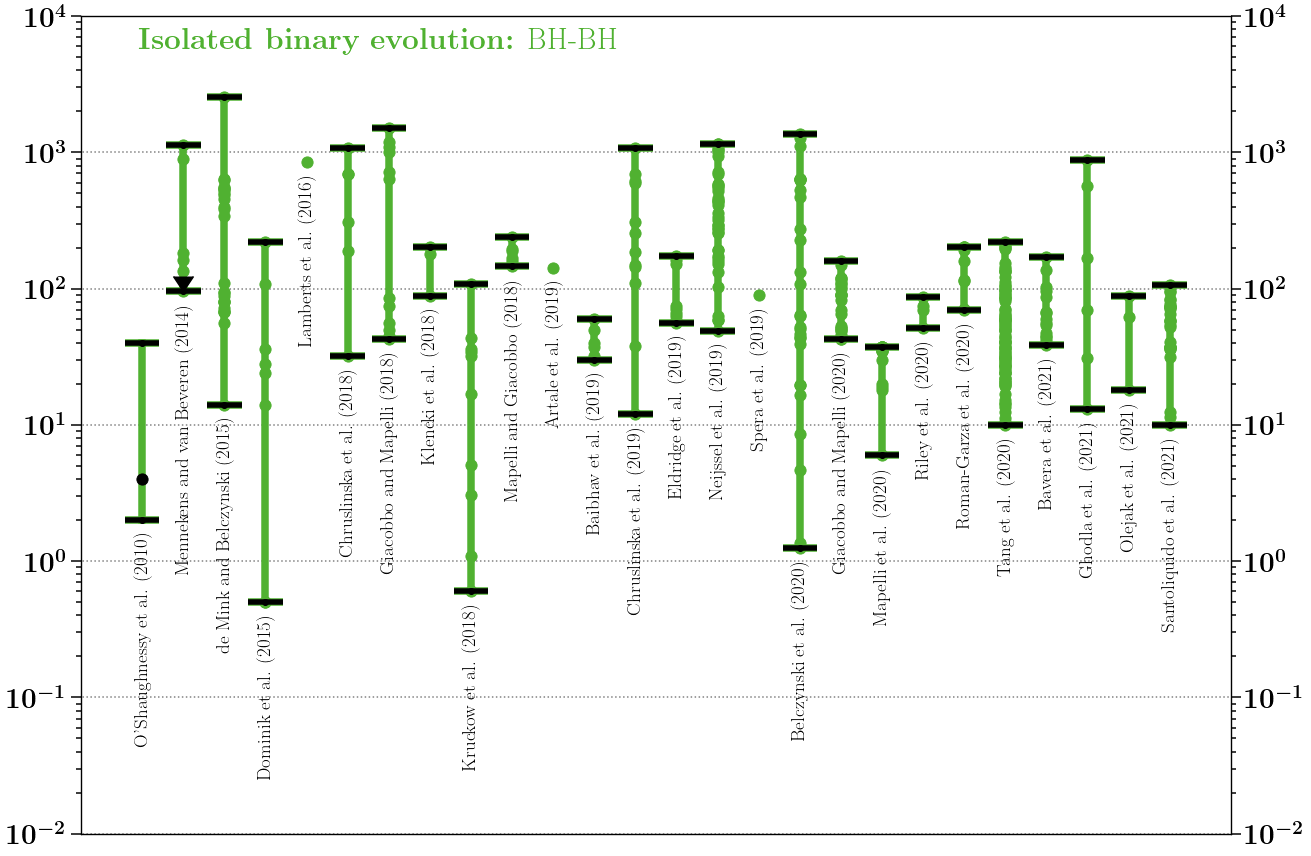

../Data/BHNS_intrinsic_isolated-binary-evolution_zoom.csv
17.0
total v length: -25 
 including empty lines


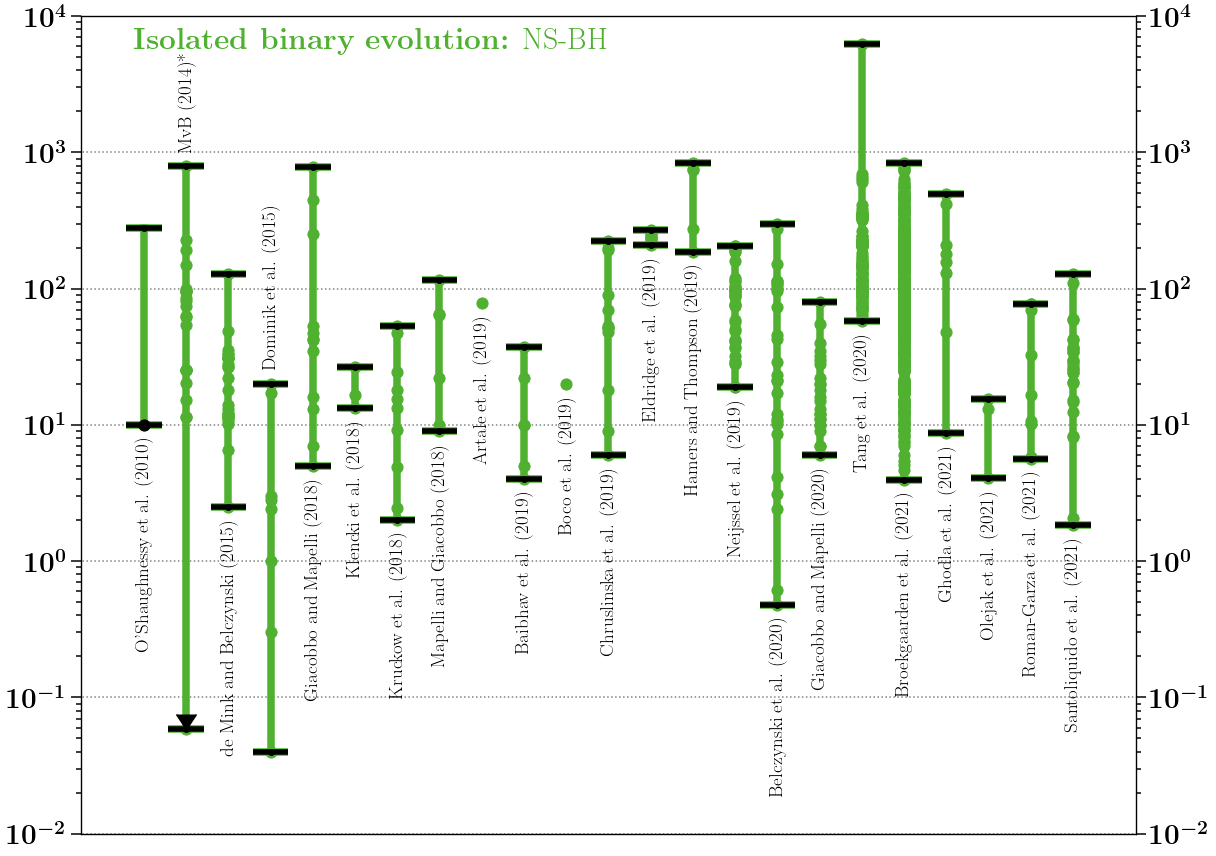

../Data/NSNS_intrinsic_isolated-binary-evolution_zoom.csv
17.0
total v length: -25 
 including empty lines


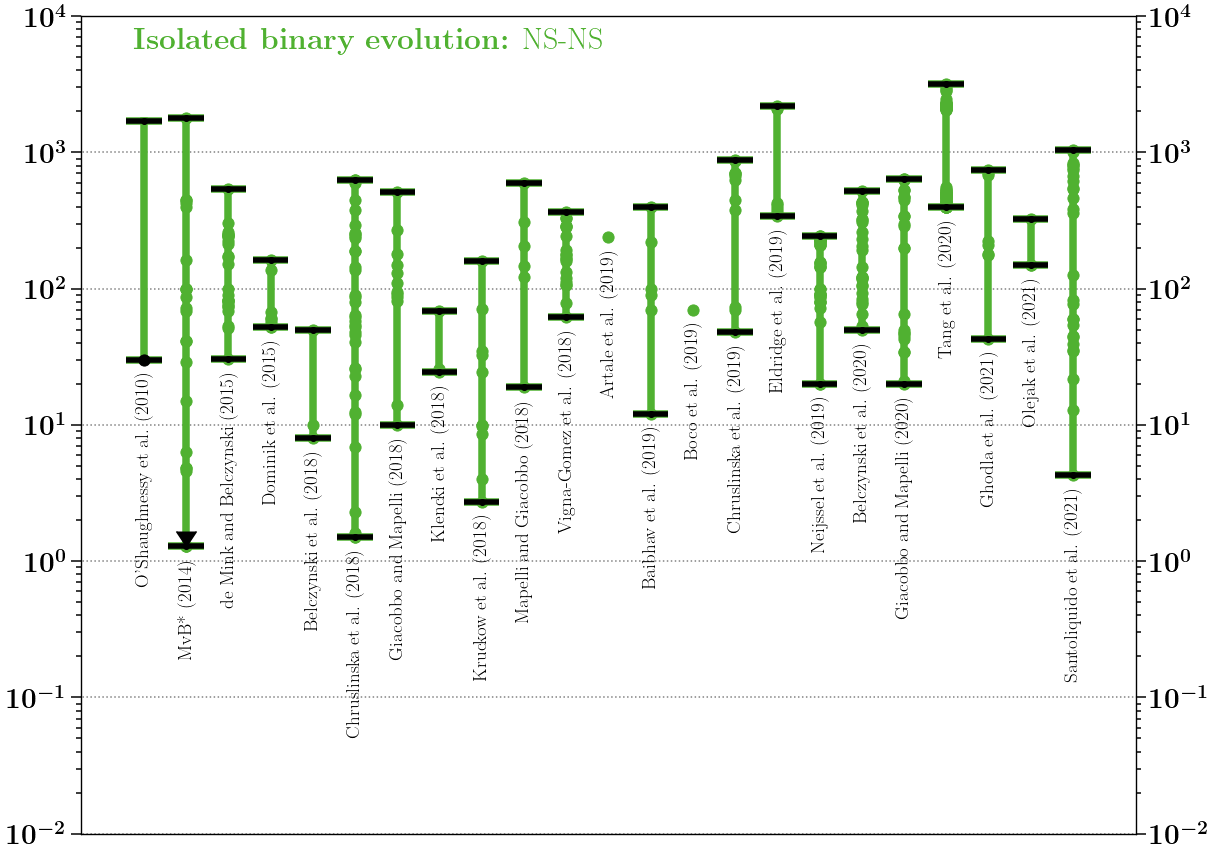

In [265]:
for DCOtype in ['BHBH', 'BHNS', 'NSNS']:    
    if DCOtype=='BHBH':
        labels =['GWs', \
                           'isolated binaries', 'CHE', 'pop-III', \
                       'triples','dynamical: GC', 'dynamical: NC', \
                       'dynamical: YSC',    'primordial']
        ind_l = 1
        vlengths = [4, 28, 6, 7, 6, 16, 16, 9]
    elif DCOtype=='NSNS':
        labels =['GWs', 'sGRBs', 'kilonovae', 'pulsars', \
                           'isolated binaries',  \
                       'triples','dynamical: GC', 'dynamical: NC', \
                       'dynamical: YSC']
        vlengths = [3, 9, 8, 5, 25, 3, 7,7, 3]
        ind_l = 4
    elif DCOtype=='BHNS':
        labels = ['GWs', \
                           'isolated binaries', 'CHE', 'pop-III', \
                       'triples','dynamical: GC', 'dynamical: NC', \
                       'dynamical: YSC']
        vlengths = [4, 25, 3, 3, 4, 5, 7, 4]
        ind_l = 1
        
        
#     for ind_l, label in enumerate(labels):
    
    label = 'isolated binaries'
    make_figure_zoom(DCOtype, ordered='year', label=label, vlength=vlengths[ind_l], ylim=[1E-2, 1E4])